In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('dark')
plt.rcParams['figure.figsize'] = [12, 5] # default = [6.0, 4.0]
plt.rcParams['figure.dpi']     = 200     # default = 72.0

import warnings
warnings.filterwarnings('ignore')

### utility functions

In [184]:
def get_data(independent_var_path, transformed_dependent=True):
    
    """
    Returns the encoded, scaled data given a path of independent variable file.
    
    Input: 
            independent_var_path:   str
                                    file path of independent variable
                                    
            transformed_dependent:  bool
                                    True/False
                                    if true returns a dependent variable with sqrt transformation applied.
            
    """
    path = independent_var_path
    
    X = pd.read_csv(path)
    target = pd.read_csv('../data/dependent-variable.csv')
    
    if transformed_dependent==True:
        y = target['Rented Bike Count_sqrt']
        
    else:
        y= target['Rented Bike Count']
        
    return X, y 

In [185]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

def feature_scale_encode(df):
    
    seasons   = ['Spring', 'Summer', 'Autumn', 'Winter']
    holidays  = ['No Holiday', 'Holiday']
    functional= ['No', 'Yes']
    month     = ['January', 'February', 'March', 'April', 'May', 'June','July', 'August', 'September', 'October', 'November','December']

    oe=OrdinalEncoder(categories=[seasons, holidays, functional, month])
    sc=StandardScaler()

    oe_cols = ['Seasons', 'Holiday', 'Functioning Day', 'month']

    sc_cols = list(df.select_dtypes(exclude='object').columns)
    sc_cols.remove('Hour')
    sc_cols.remove('day')

    ct = ColumnTransformer(transformers=[
                                            ('ordinal', oe, oe_cols),
                                            ('StandardScaler', sc, sc_cols)
                                        ],
                          remainder='passthrough')
    return ct

In [186]:
from sklearn.model_selection import train_test_split

def train_test_split_enc(X, y, test_size=0.2,random_state=42):
    x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                       test_size=test_size,
                                                       random_state=random_state)
    ct = feature_scale_encode(X)
    
    ct.fit(x_train)
    x_train = ct.transform(x_train)
    x_test = ct.transform(x_test)
    
    
    print('=='*40)
    print(f'Train set size = {x_train.shape}')
    print(f'Test set size = {x_test.shape}')
    
    return (x_train,y_train), (x_test, y_test)

In [187]:
import statsmodels.api as sm

def ols(x_train, y_train):
    # adding the constant term
    x_train = sm.add_constant(x_train)

    # performing the regression
    # and fitting the model
    result = sm.OLS(y_train, x_train).fit()

    # printing the summary table
    print(result.summary())
    
    return result

In [188]:
scores=dict()

def build_model(model, x_train, y_train, x_test, y_test):
    
    model.fit(x_train, y_train)
    model_score = model.score(x_train, y_train)
    algo=type(model).__name__
    scores[algo]=model_score
    
    print('=='*40)
    print(f'Score of the model : {np.round(model_score, 2)}')
    
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)
    
    print('=='*40)
    
    #plot original vs predicted signal
    plt.subplots(1, 2)

    plt.subplot(121)
    plt.plot(y_train[:100].values, label= 'y_train')
    plt.plot((y_pred_train)[:100], label= 'Predicted y_train')
    plt.title('Original vs Predicted signal of training data')
    plt.legend()

    plt.subplot(122)
    plt.plot(y_test[:100].values, label= 'y_train')
    plt.plot((y_pred_test)[:100], label= 'Predicted y_test')
    plt.title('Original vs Predicted signal of test data')
    plt.legend()

    plt.suptitle(f'Model: {type(model).__name__}')

    fname='Original vs Predicted signal'+ type(model).__name__

    plt.savefig(os.path.join('../graphs', fname))
    plt.show()
        
    return y_pred_train, y_pred_test

In [189]:
# Definig function for evaluating model
from sklearn import metrics

#Evaluate Metrics
def evaluate_model(model, y_true, y_pred): 
    
    mse = metrics.mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_true, y_pred))
    mae = metrics.mean_absolute_error(y_true, y_pred)
    r2_square = metrics.r2_score(y_true, y_pred)
    
    adjusted_r2 = (1 - (1-model.score(x_train, y_train))*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1))
    
    print('=='*40)
    print('Mean squared error (MSE):', np.round(mse,2))
    print('Root mean squared error (RMSE):', np.round(rmse, 2))
    print('Mean absolute error (MAE):', np.round(mae,2))
    print('R2 Square', np.round(r2_square, 2))
    print('Adjusted R2 sqaure', np.round(adjusted_r2,2))
    
    return mse, rmse, mae, r2_square, adjusted_r2

In [190]:
def get_results(model, y_train, y_pred_train, y_test, y_pred_test):
    
    y_train=y_train
    y_pred_train=y_pred_train
    y_test=y_test
    y_pred_test=y_pred_test
    model=model
    
    results=dict() 

    print('=='*40)
    print('Train set evaluation results:')
    mse, rmse, mae, r2, adjusted_r2 = evaluate_model(model, y_train, y_pred_train)
    
    results['train_set_results'] = {
                                    'mse':  mse,
                                    'rmse': rmse,
                                    'mae':  mae,
                                    'r2':   r2,
                                    'adjusted_r2':adjusted_r2
                                    }

    print('\n')
    print('=='*40)
    print('Test set evaluation results:')
    mse, rmse, mae, r2, adjusted_r2 = evaluate_model(model, y_test, y_pred_test)
    results['test_set_results'] = {
                                    'mse':  mse,
                                    'rmse': rmse,
                                    'mae':  mae,
                                    'r2':   r2,
                                    'adjusted_r2':adjusted_r2
                                    }

    
    return results

In [191]:
def residual_analysis(model, preds, y_test):
    
    algo=type(model).__name__
    
    residuals = y_test-preds['y_pred_test']
    mean = np.mean(residuals)
    
    print('=='*40)
    print('Mean of the residuals for '+ algo+' is:', mean )
    print('=='*40)
    
    plt.subplots(1,2)

    plt.subplot(121)
    sns.histplot(x=residuals, kde=True, color='c')
    plt.axvline(x= np.mean(residuals), linestyle='--', color='r', label='mean')
    plt.title('Distribution of residuals')
    plt.legend()

    plt.subplot(122)
    sns.scatterplot(x=y_test, y=residuals,alpha=0.25, color='c')
    plt.axhline(y=0, linestyle='--', color='maroon')
    plt.xlabel('y_test')
    plt.ylabel('residuals')
    plt.title('residuals vs expected')
    
    fname = 'Residual Analysis- '+ algo

    plt.suptitle(fname)
    plt.savefig(os.path.join('../graphs', fname))
    plt.show()

In [192]:
predictions=dict()
measures=dict()

def train_model(model, x_train, y_train, x_test, y_test):
    
    """
    Trains the given model and stores the results
    """
    model=model
    x_train=x_train
    y_train=y_train
    x_test=x_test
    y_test=y_test
        
    algo=type(model).__name__
    preds=dict()
    
    #build a model
    y_pred_train, y_pred_test = build_model(model, x_train, y_train, x_test, y_test)
    preds['y_pred_train'] = y_pred_train
    preds['y_pred_test'] = y_pred_test
    
    #evaluate a model
    results = get_results(model, y_train, y_pred_train, y_test, y_pred_test)
    
    #check residuals
    print('\n')
    residual_analysis(model, preds, y_test)
    
    #store results
    predictions[algo] = preds
    measures[algo]= results
    
    return preds, results

## 1.0 Modeling Original Data

In [193]:
X_path = '../data/original-independent-vars.csv'

X, y = get_data(X_path)

In [194]:
(x_train,y_train), (x_test, y_test) = train_test_split_enc(X, y, test_size=0.2,random_state=42)

Train set size = (7008, 12)
Test set size = (1752, 12)


### 1.1 OLS

In [195]:
og_ols_result =ols(x_train, y_train)

                              OLS Regression Results                              
Dep. Variable:     Rented Bike Count_sqrt   R-squared:                       0.578
Model:                                OLS   Adj. R-squared:                  0.578
Method:                     Least Squares   F-statistic:                     799.8
Date:                    Mon, 23 Oct 2023   Prob (F-statistic):               0.00
Time:                            13:00:06   Log-Likelihood:                -24553.
No. Observations:                    7008   AIC:                         4.913e+04
Df Residuals:                        6995   BIC:                         4.922e+04
Df Model:                              12                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

### 1.2 Simple Linear Regression

Score of the model : 0.58


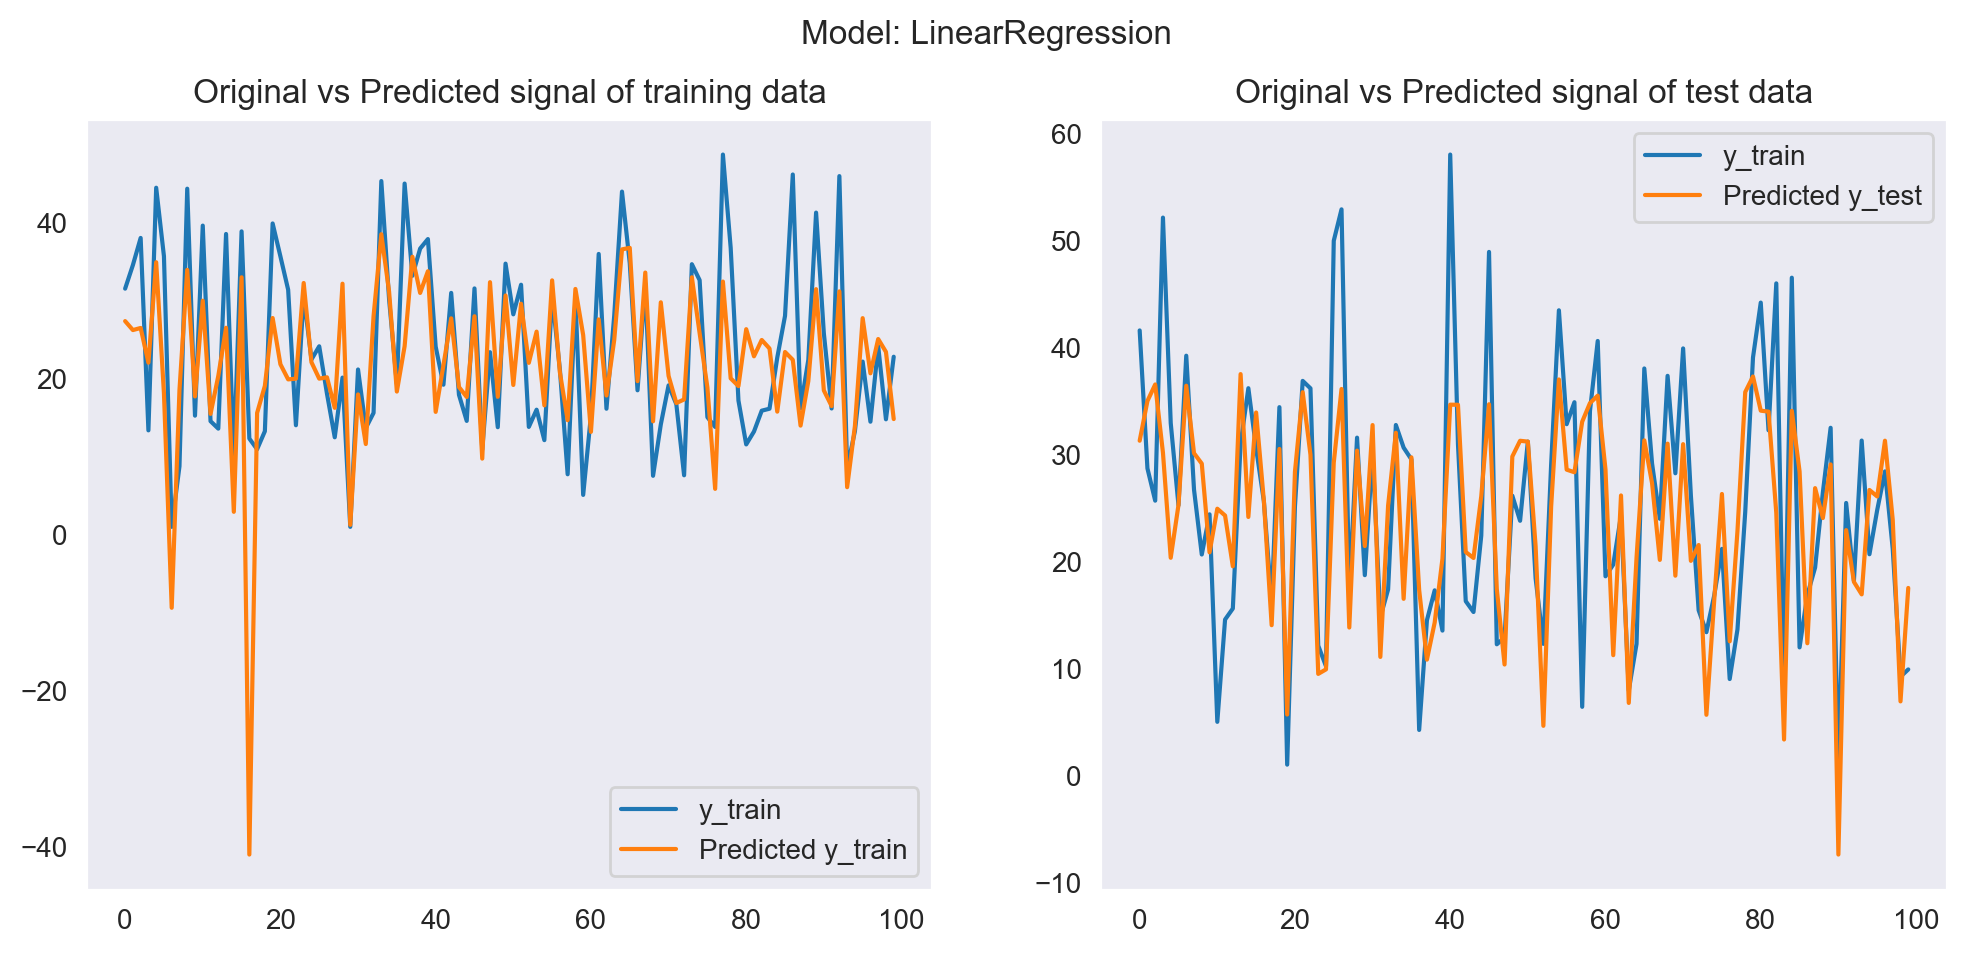

Train set evaluation results:
Mean squared error (MSE): 64.66
Root mean squared error (RMSE): 8.04
Mean absolute error (MAE): 6.22
R2 Square 0.58
Adjusted R2 sqaure 0.58


Test set evaluation results:
Mean squared error (MSE): 67.71
Root mean squared error (RMSE): 8.23
Mean absolute error (MAE): 6.27
R2 Square 0.55
Adjusted R2 sqaure 0.58


Mean of the residuals for LinearRegression is: 0.20843942025913131


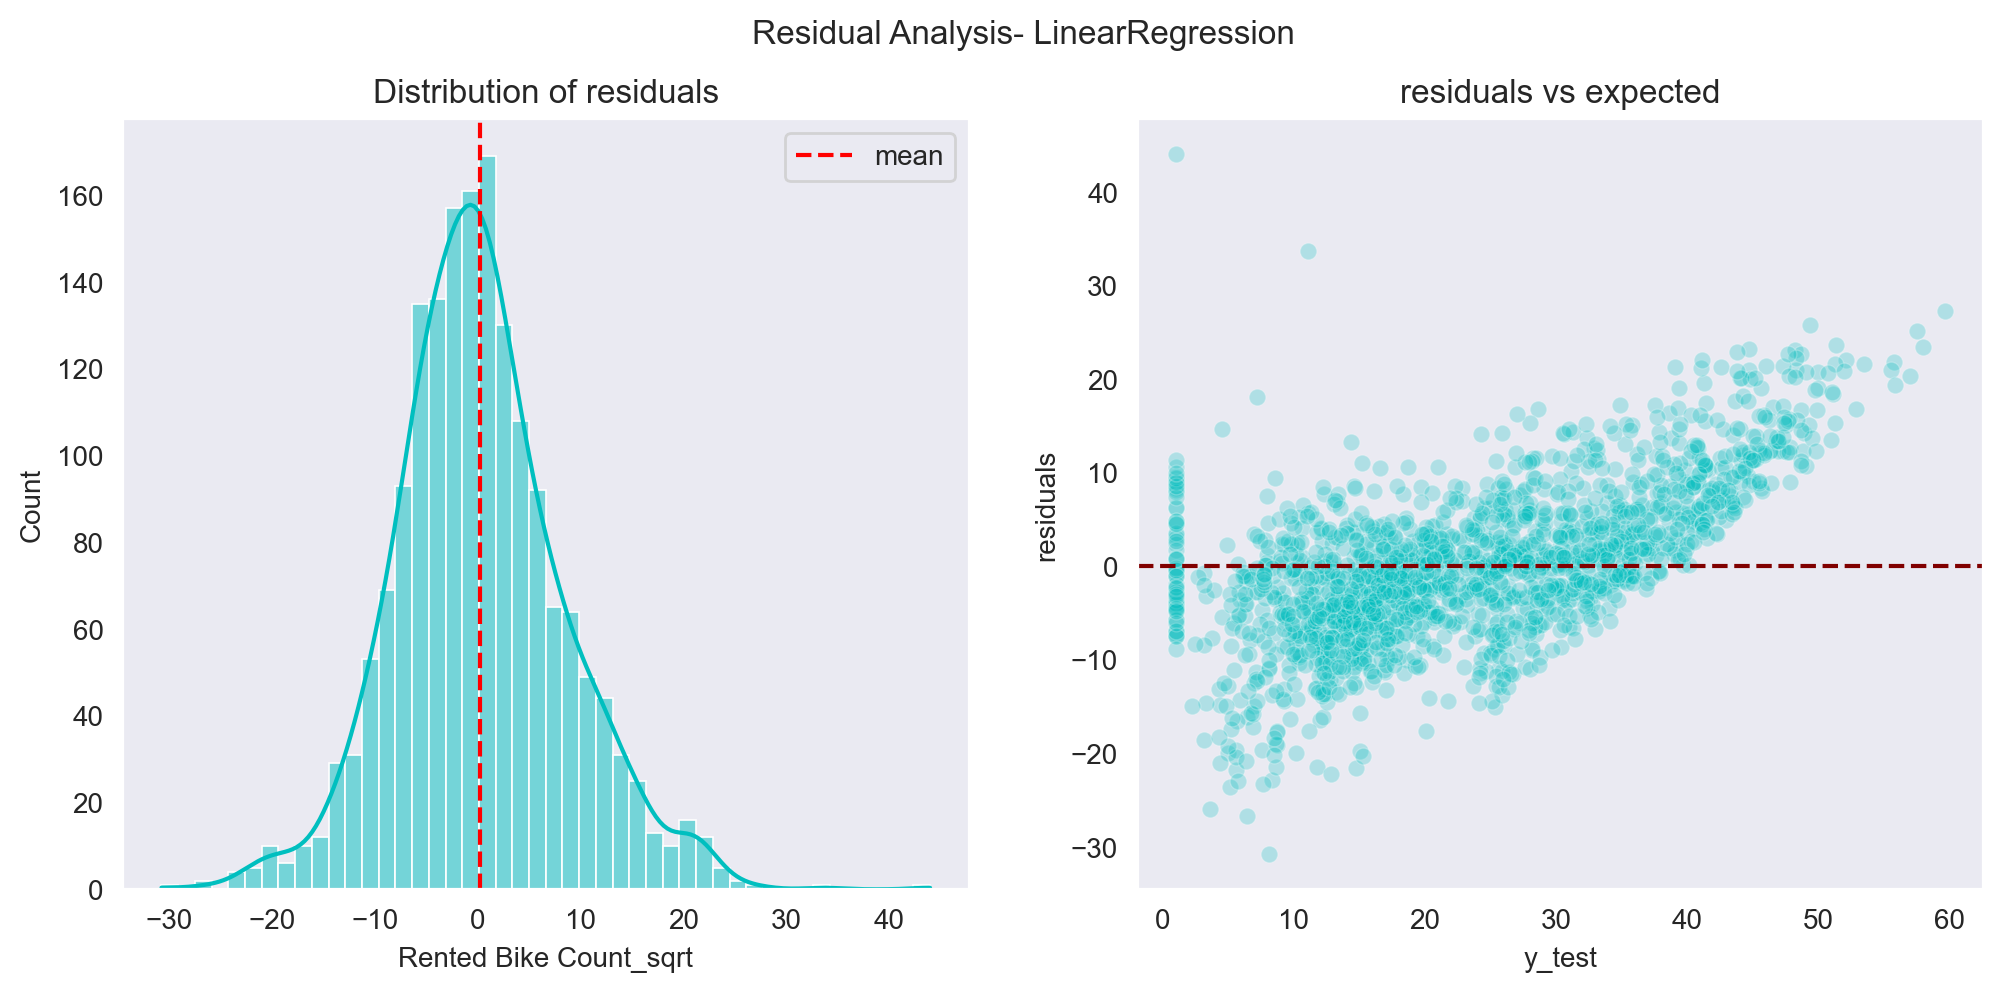

In [196]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
preds, results = train_model(lr, x_train, y_train, x_test, y_test)

- The low RMSE and R2 square values on both train and test set suggests that the linear model fails to perform well based on the above model results and graph.
- Model yielded only 58% of the performance score.
- Residuals seems to be normally distributed with mean of residuals close to zero. However the residuals vs y_test plot suggests that the residuals doesn't has constant variance

### 1.2 Lasso Regression

In [197]:
# Fitting lasso regression model to training set
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

lasso = Lasso(alpha=0.0001 , max_iter= 3000, random_state=42)
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100,0.0014]}
lasso_reg = GridSearchCV(lasso, parameters, verbose=1, scoring='neg_mean_squared_error', cv=5)
lasso_reg.fit(x_train, y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


GridSearchCV(cv=5,
             estimator=Lasso(alpha=0.0001, max_iter=3000, random_state=42),
             param_grid={'alpha': [1e-15, 1e-13, 1e-10, 1e-08, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1, 1, 5, 10, 20, 30, 40, 45,
                                   50, 55, 60, 100, 0.0014]},
             scoring='neg_mean_squared_error', verbose=1)

In [198]:
lasso_reg.best_params_

{'alpha': 0.0014}

Score of the model : 0.58


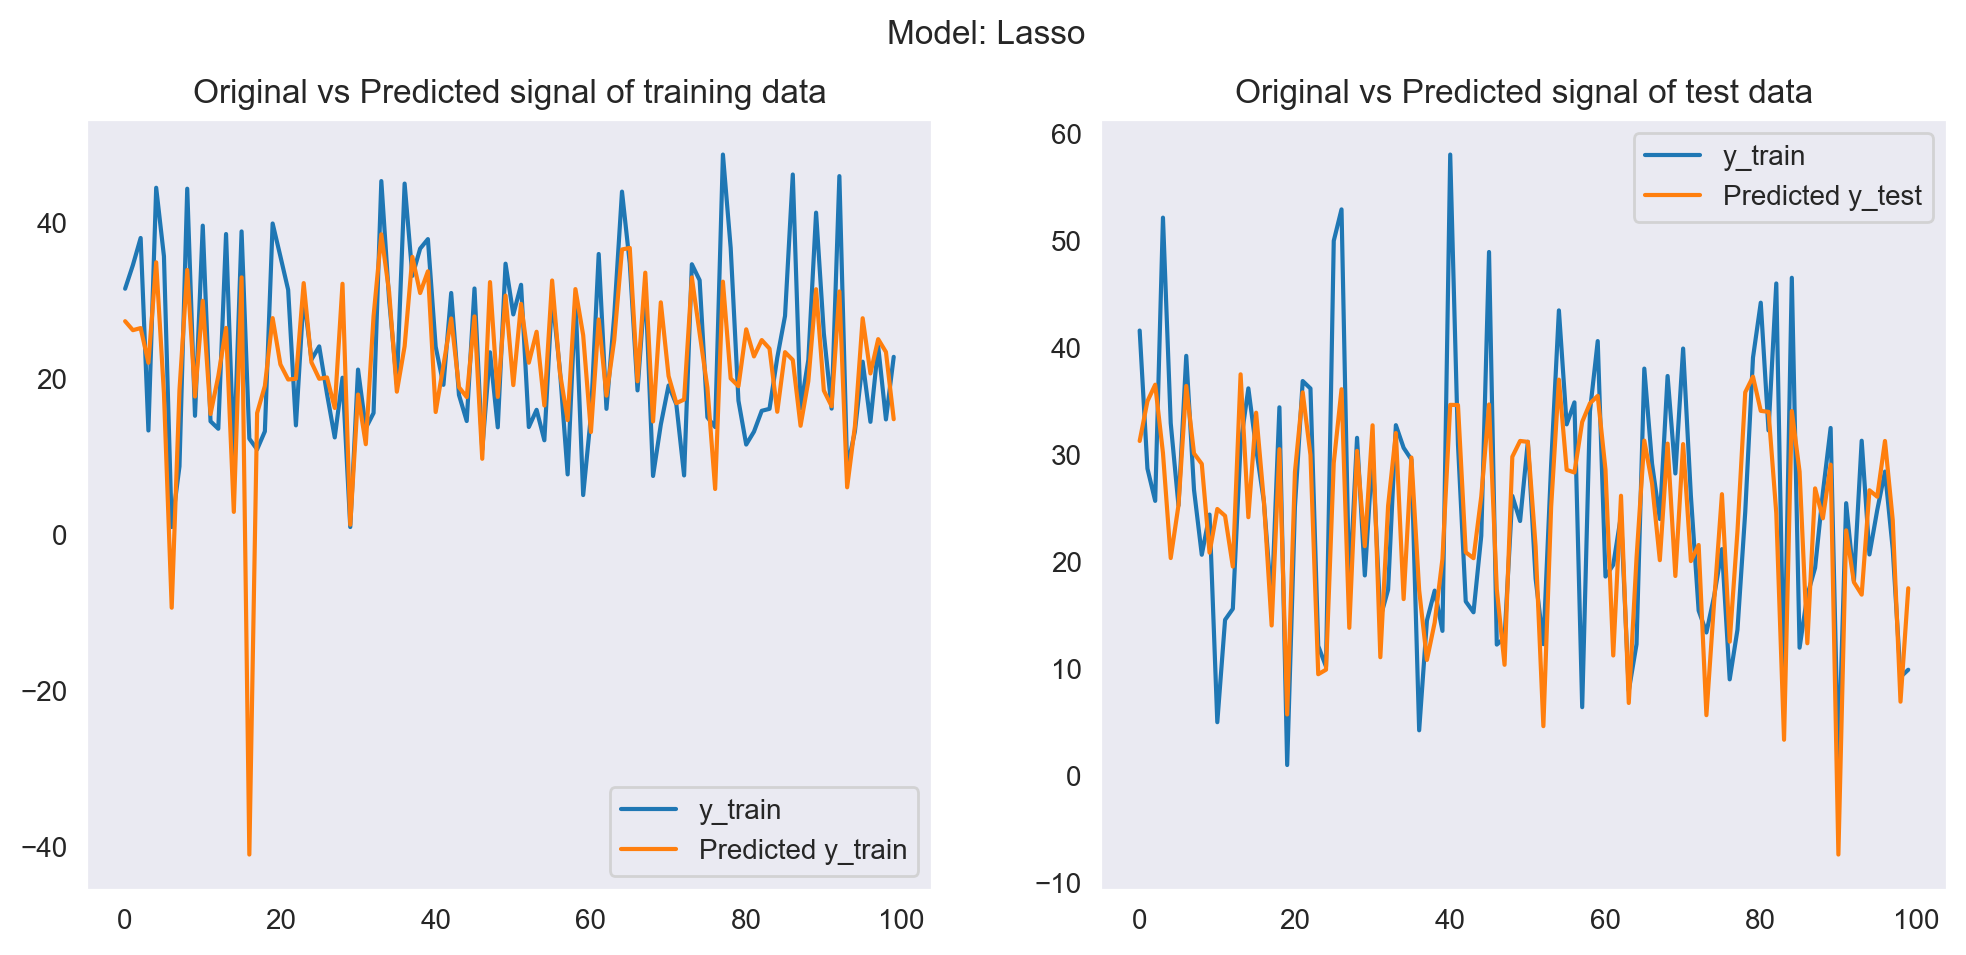

Train set evaluation results:
Mean squared error (MSE): 64.66
Root mean squared error (RMSE): 8.04
Mean absolute error (MAE): 6.22
R2 Square 0.58
Adjusted R2 sqaure 0.58


Test set evaluation results:
Mean squared error (MSE): 67.7
Root mean squared error (RMSE): 8.23
Mean absolute error (MAE): 6.27
R2 Square 0.55
Adjusted R2 sqaure 0.58


Mean of the residuals for Lasso is: 0.2085965669129513


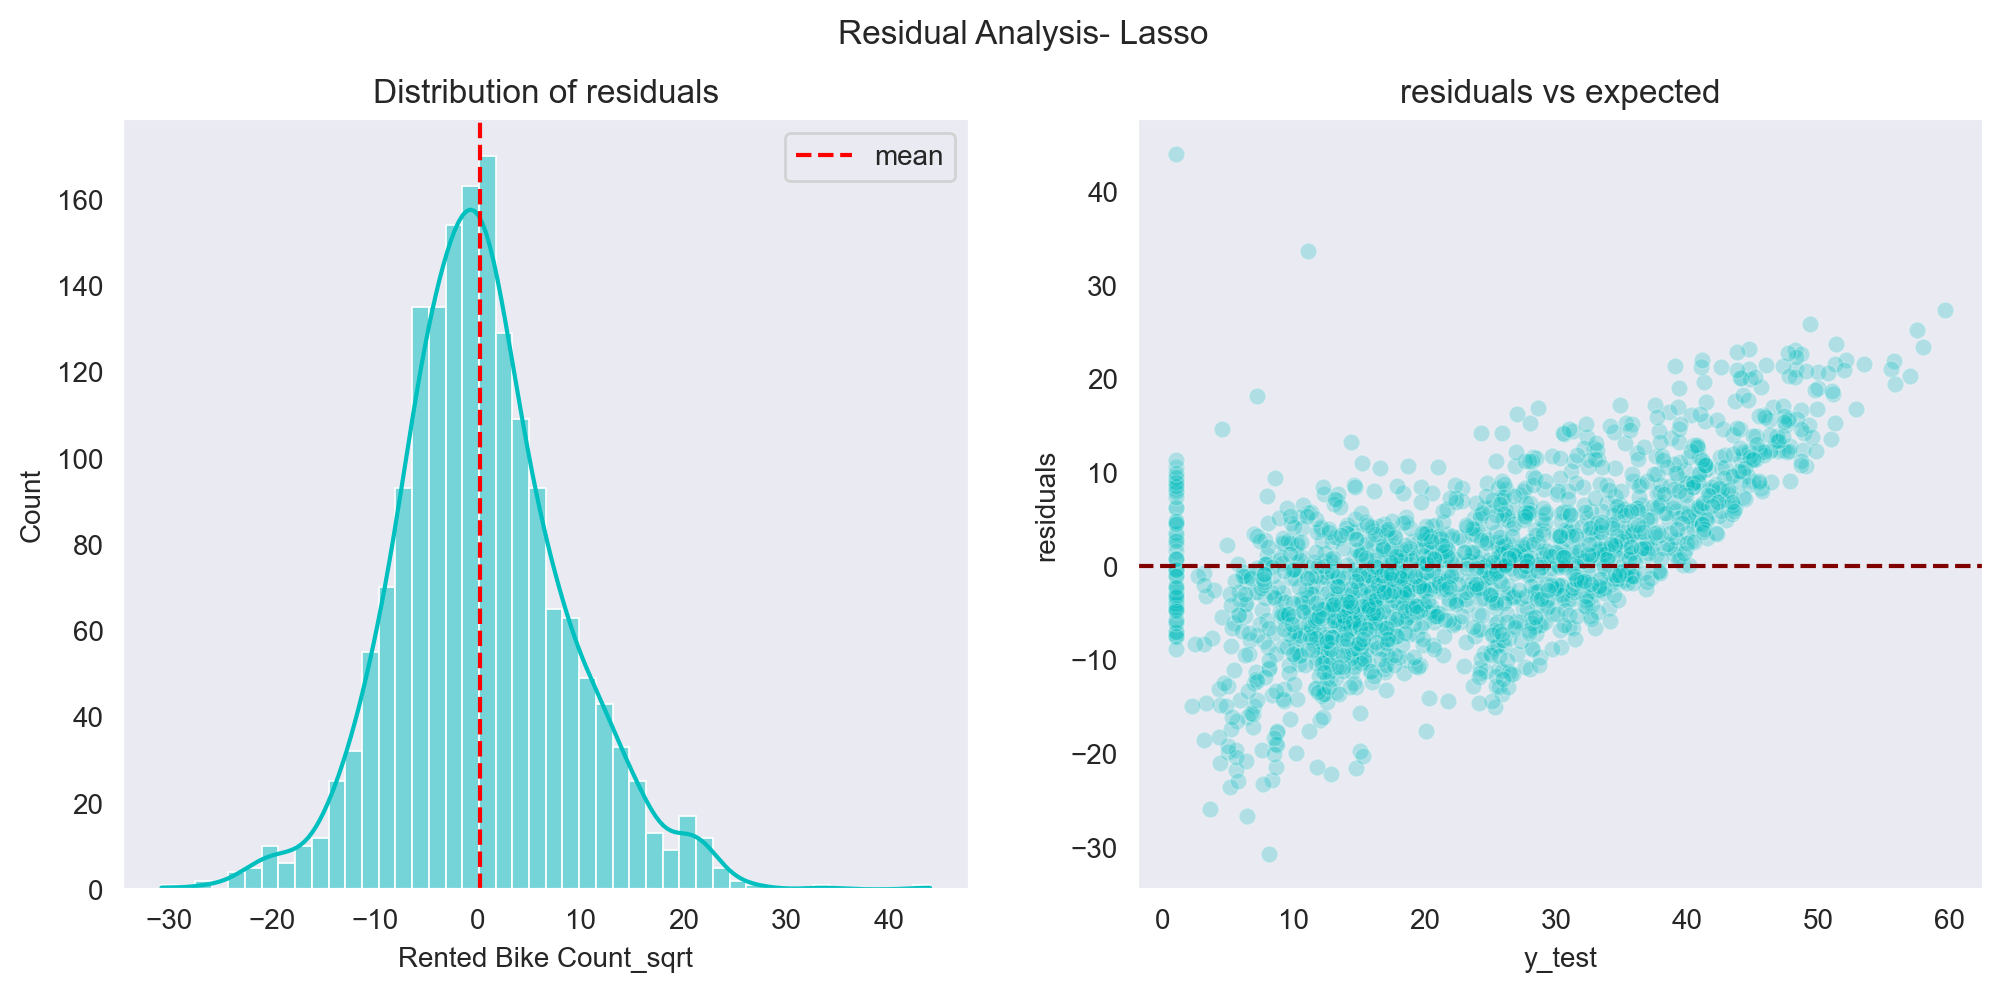

In [200]:
lasso = Lasso(alpha=0.0014, max_iter= 3000, random_state=42)
preds, results = train_model(lasso, x_train, y_train, x_test, y_test)

- The Lasso (L1) regression model yields the same performance as the linear regression model.

### 1.3 Ridge Regression (L2)

In [201]:
# Fitting ridge regression model to training set
from sklearn.linear_model import Ridge
ridge = Ridge(random_state=42)
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100,0.0014]}
ridge_reg = GridSearchCV(ridge, parameters, verbose=1, scoring='neg_mean_squared_error', cv=5)
ridge_reg.fit(x_train, y_train)
print(ridge_reg.best_params_)

Fitting 5 folds for each of 21 candidates, totalling 105 fits
{'alpha': 0.1}


Score of the model : 0.58


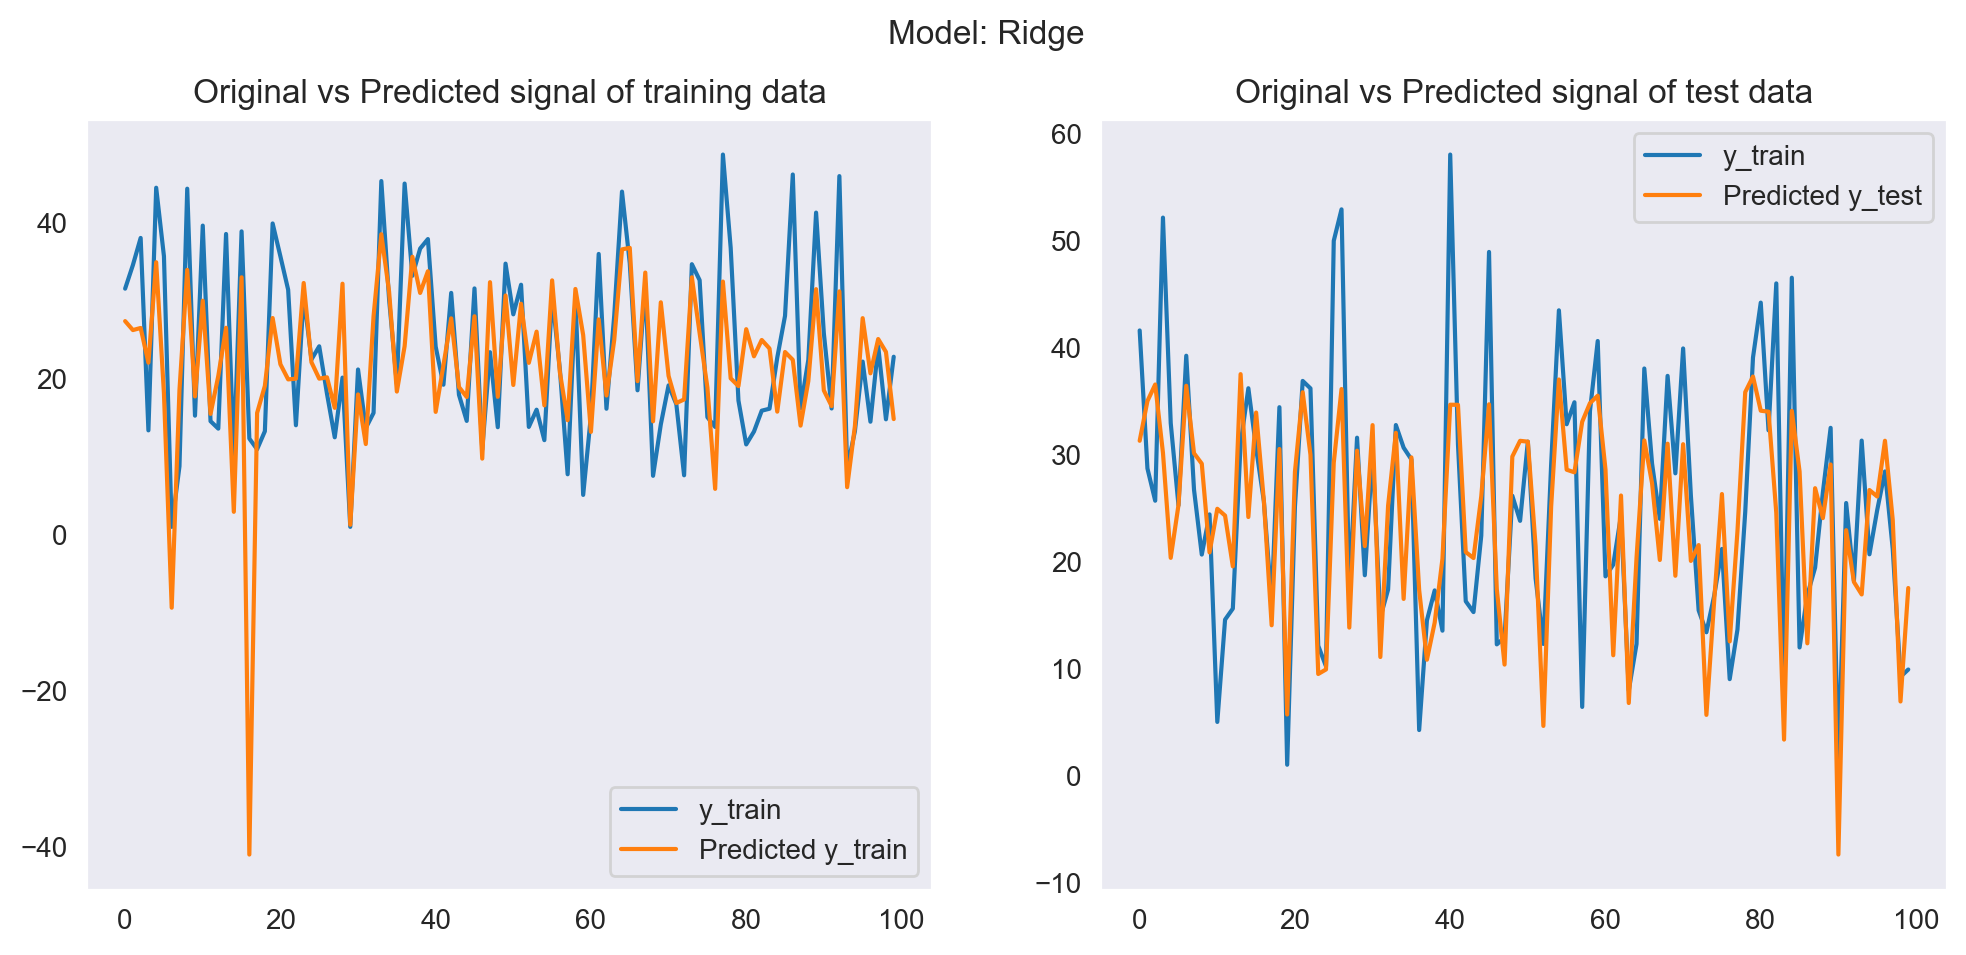

Train set evaluation results:
Mean squared error (MSE): 64.66
Root mean squared error (RMSE): 8.04
Mean absolute error (MAE): 6.22
R2 Square 0.58
Adjusted R2 sqaure 0.58


Test set evaluation results:
Mean squared error (MSE): 67.71
Root mean squared error (RMSE): 8.23
Mean absolute error (MAE): 6.27
R2 Square 0.55
Adjusted R2 sqaure 0.58


Mean of the residuals for Ridge is: 0.2084541767973199


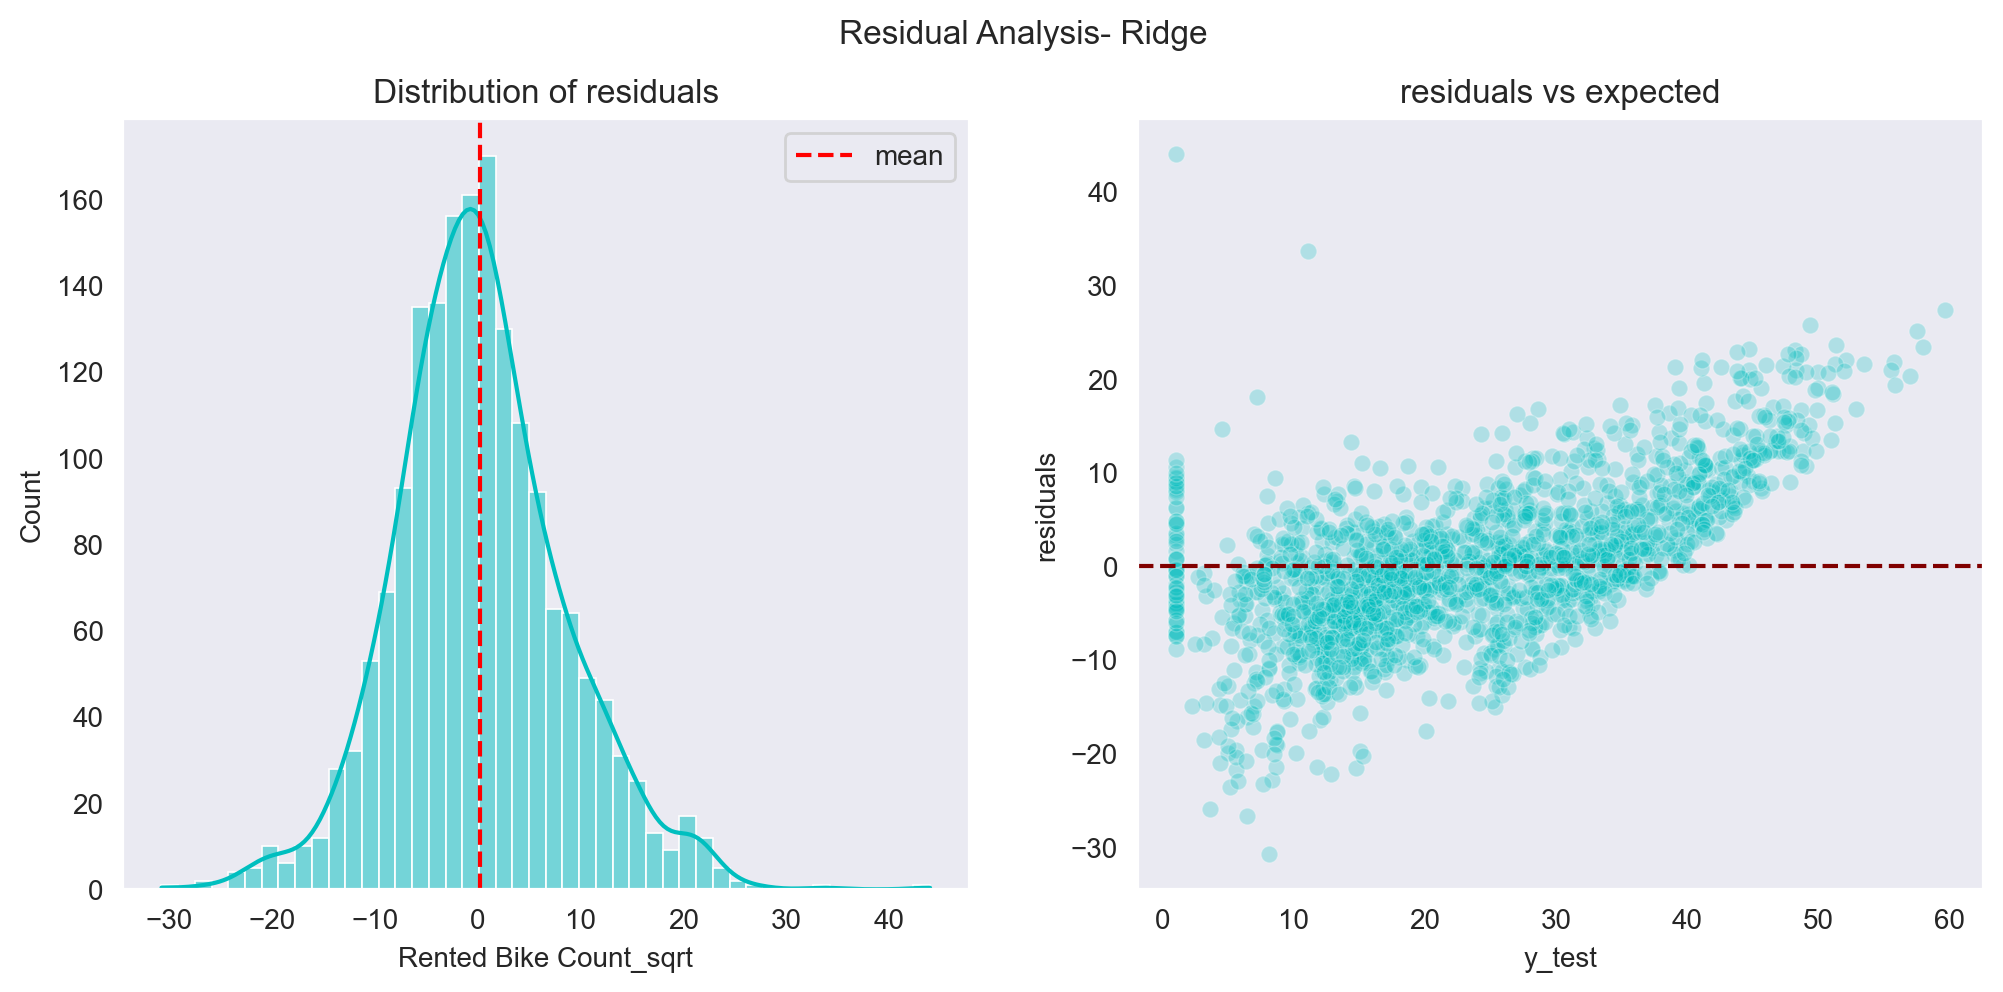

In [202]:
ridge = Ridge(alpha=0.1, random_state=42)
preds, results = train_model(ridge, x_train, y_train, x_test, y_test)

- The Ridge (L2) regression model yields the same performance as the linear regression model.

### 1.4 ElasticNet Regression

In [204]:
# Fitting elasticnet regression model to training set
from sklearn.linear_model import ElasticNet
elasticnet = ElasticNet(random_state=42)
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100,0.0014]}
enet_reg = GridSearchCV(elasticnet, parameters, verbose=1, scoring='neg_mean_squared_error', cv=5)
enet_reg.fit(x_train, y_train)
print(enet_reg.best_params_)

Fitting 5 folds for each of 21 candidates, totalling 105 fits
{'alpha': 0.0001}


Score of the model : 0.58


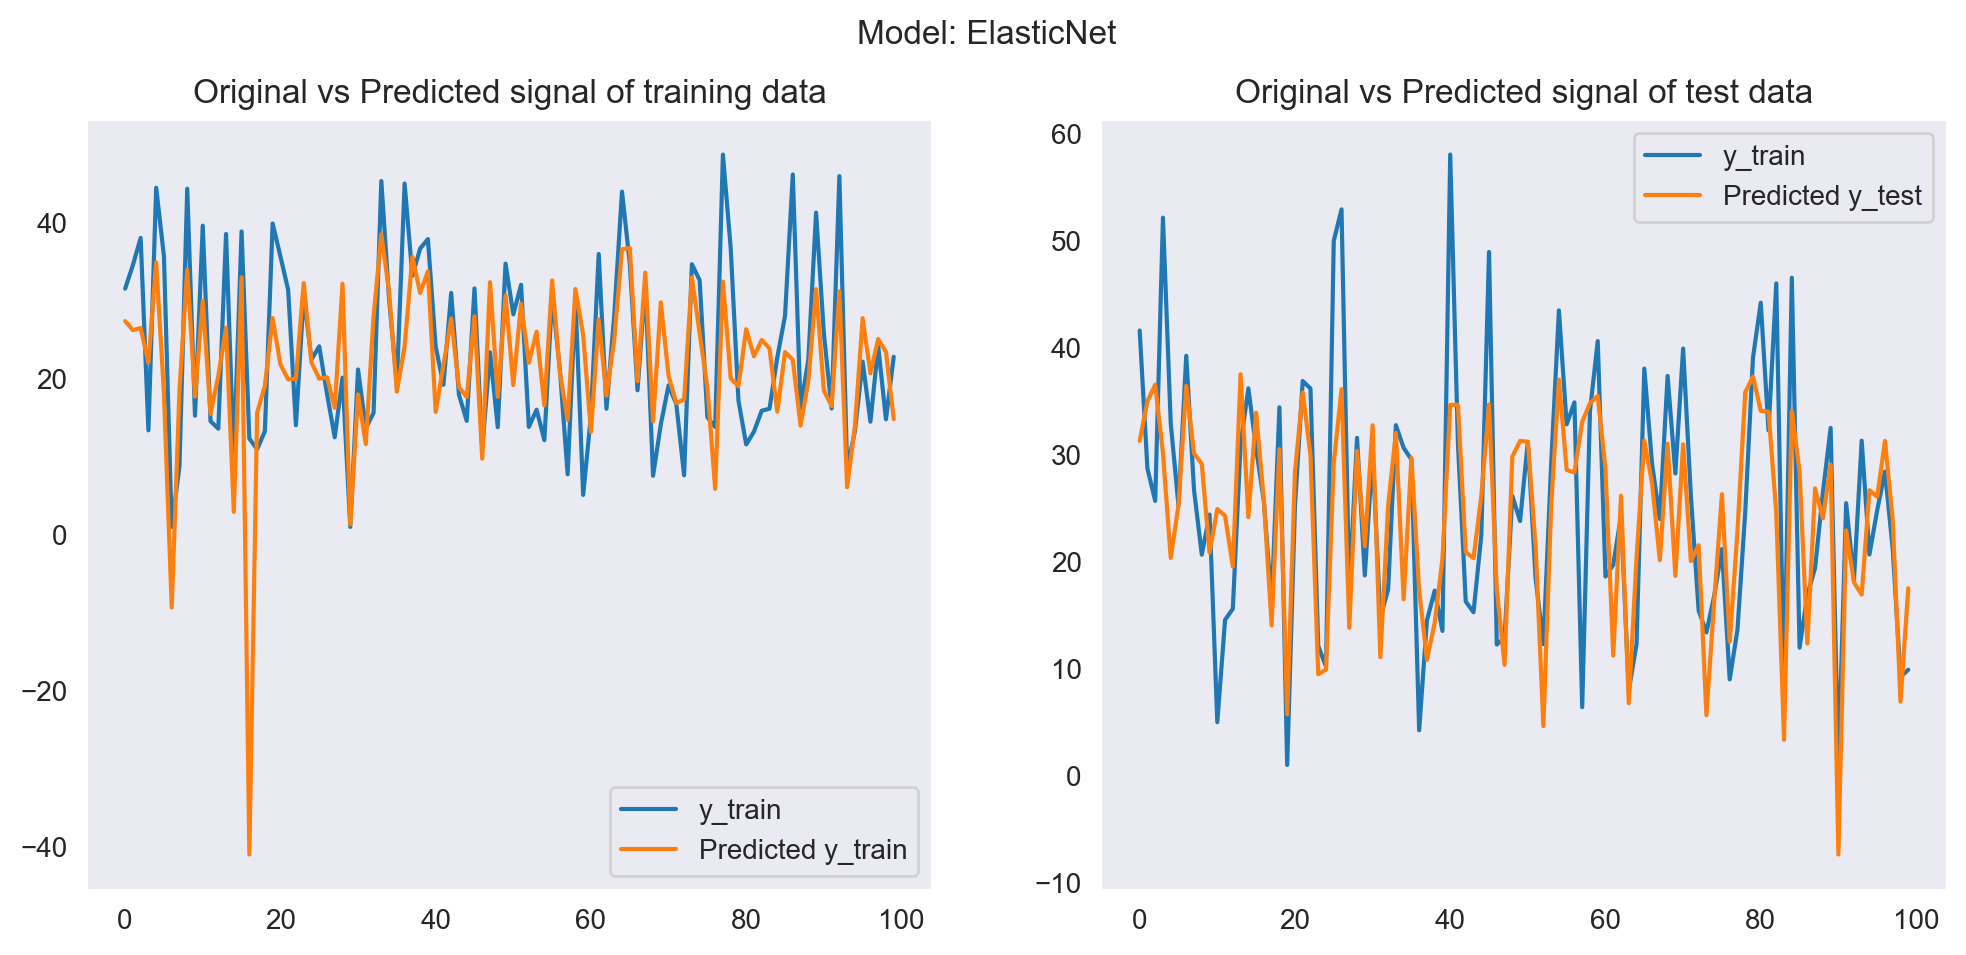

Train set evaluation results:
Mean squared error (MSE): 64.66
Root mean squared error (RMSE): 8.04
Mean absolute error (MAE): 6.22
R2 Square 0.58
Adjusted R2 sqaure 0.58


Test set evaluation results:
Mean squared error (MSE): 67.71
Root mean squared error (RMSE): 8.23
Mean absolute error (MAE): 6.27
R2 Square 0.55
Adjusted R2 sqaure 0.58


Mean of the residuals for ElasticNet is: 0.20849669888720096


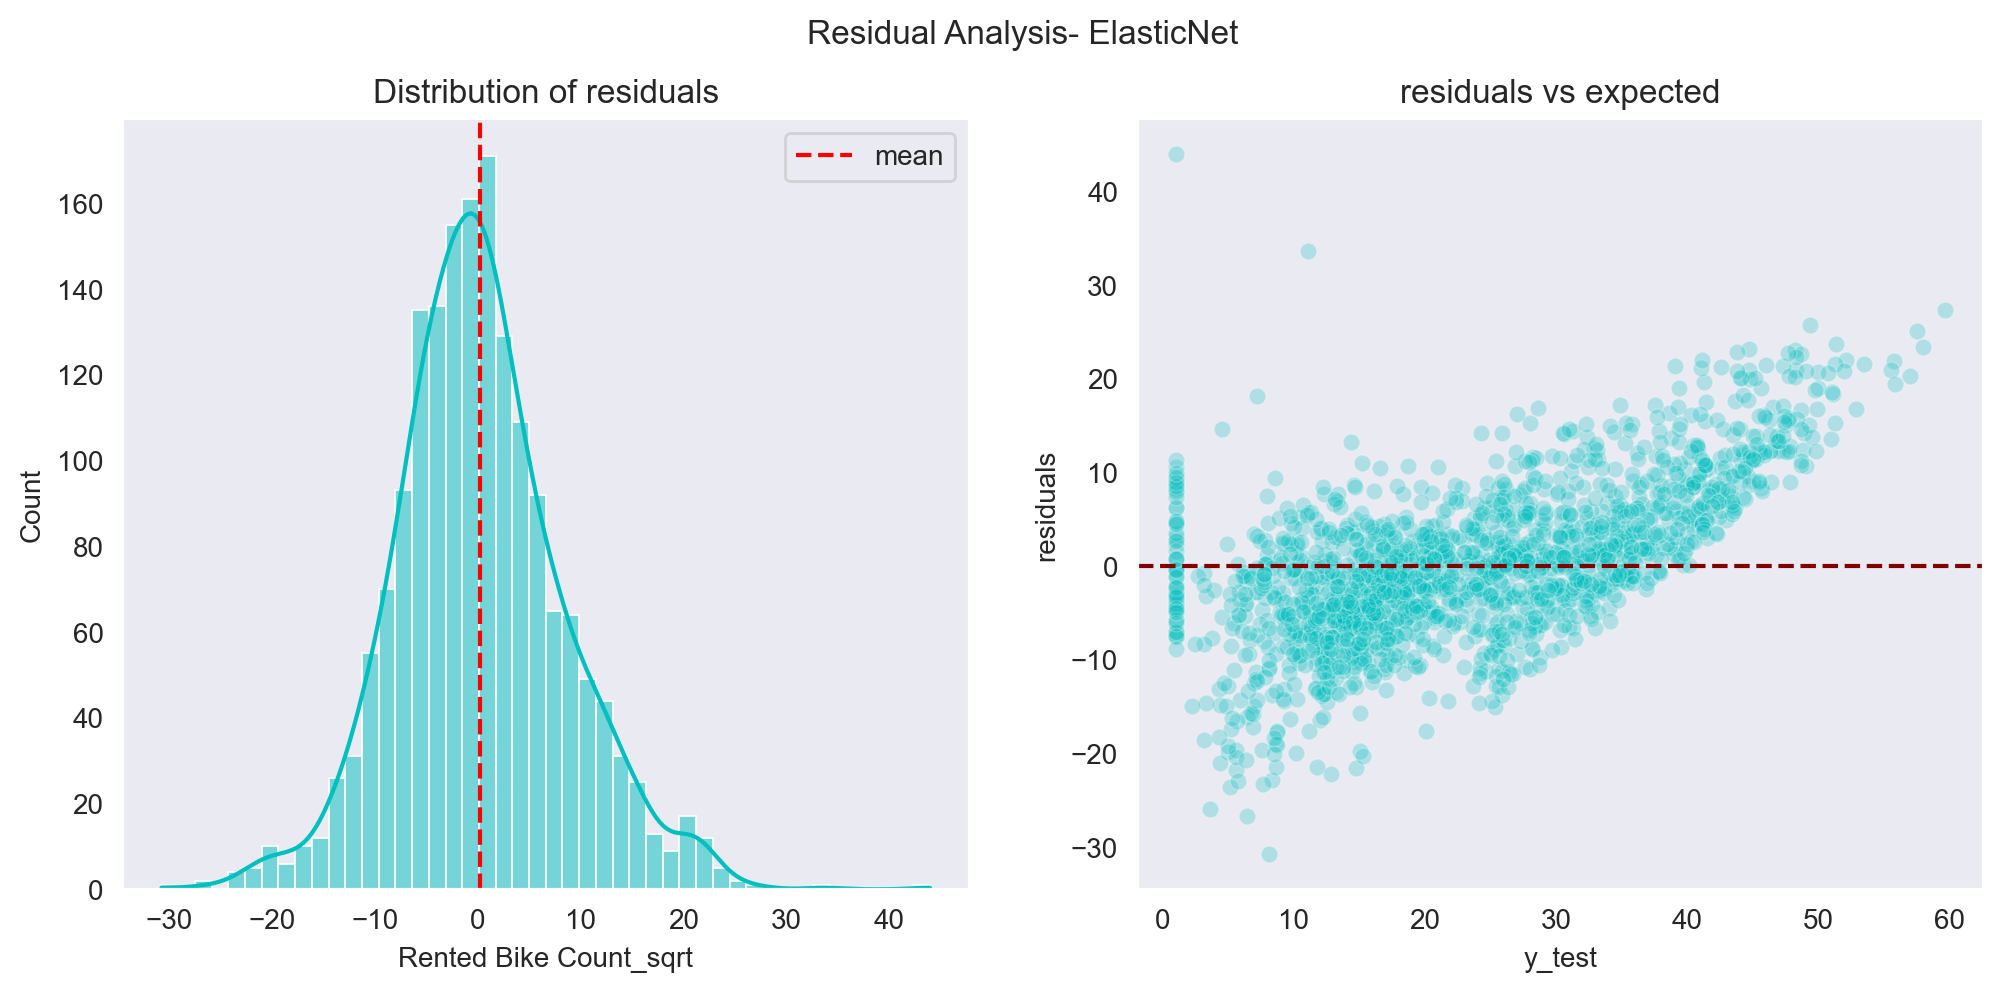

In [205]:
enet = ElasticNet(alpha=0.0001, random_state=42)
preds, results = train_model(enet, x_train, y_train, x_test, y_test)

- The Elastic Net regression model yields the same performance as the linear regression model.

### 1.5 Decision Tree Regressor

In [225]:
from sklearn.tree import DecisionTreeRegressor
dtree = DecisionTreeRegressor(random_state=42)
param_dict = {'max_leaf_nodes':[300,350, 400, 450],
              'min_samples_split':[20,30,40],
              'min_samples_leaf':[7,8,9,10,20]}
dtree_reg = GridSearchCV(dtree, param_dict, verbose=1, scoring='neg_mean_squared_error', cv=5)
dtree_reg.fit(x_train, y_train)
print(dtree_reg.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
{'max_leaf_nodes': 350, 'min_samples_leaf': 10, 'min_samples_split': 30}


Score of the model : 0.9


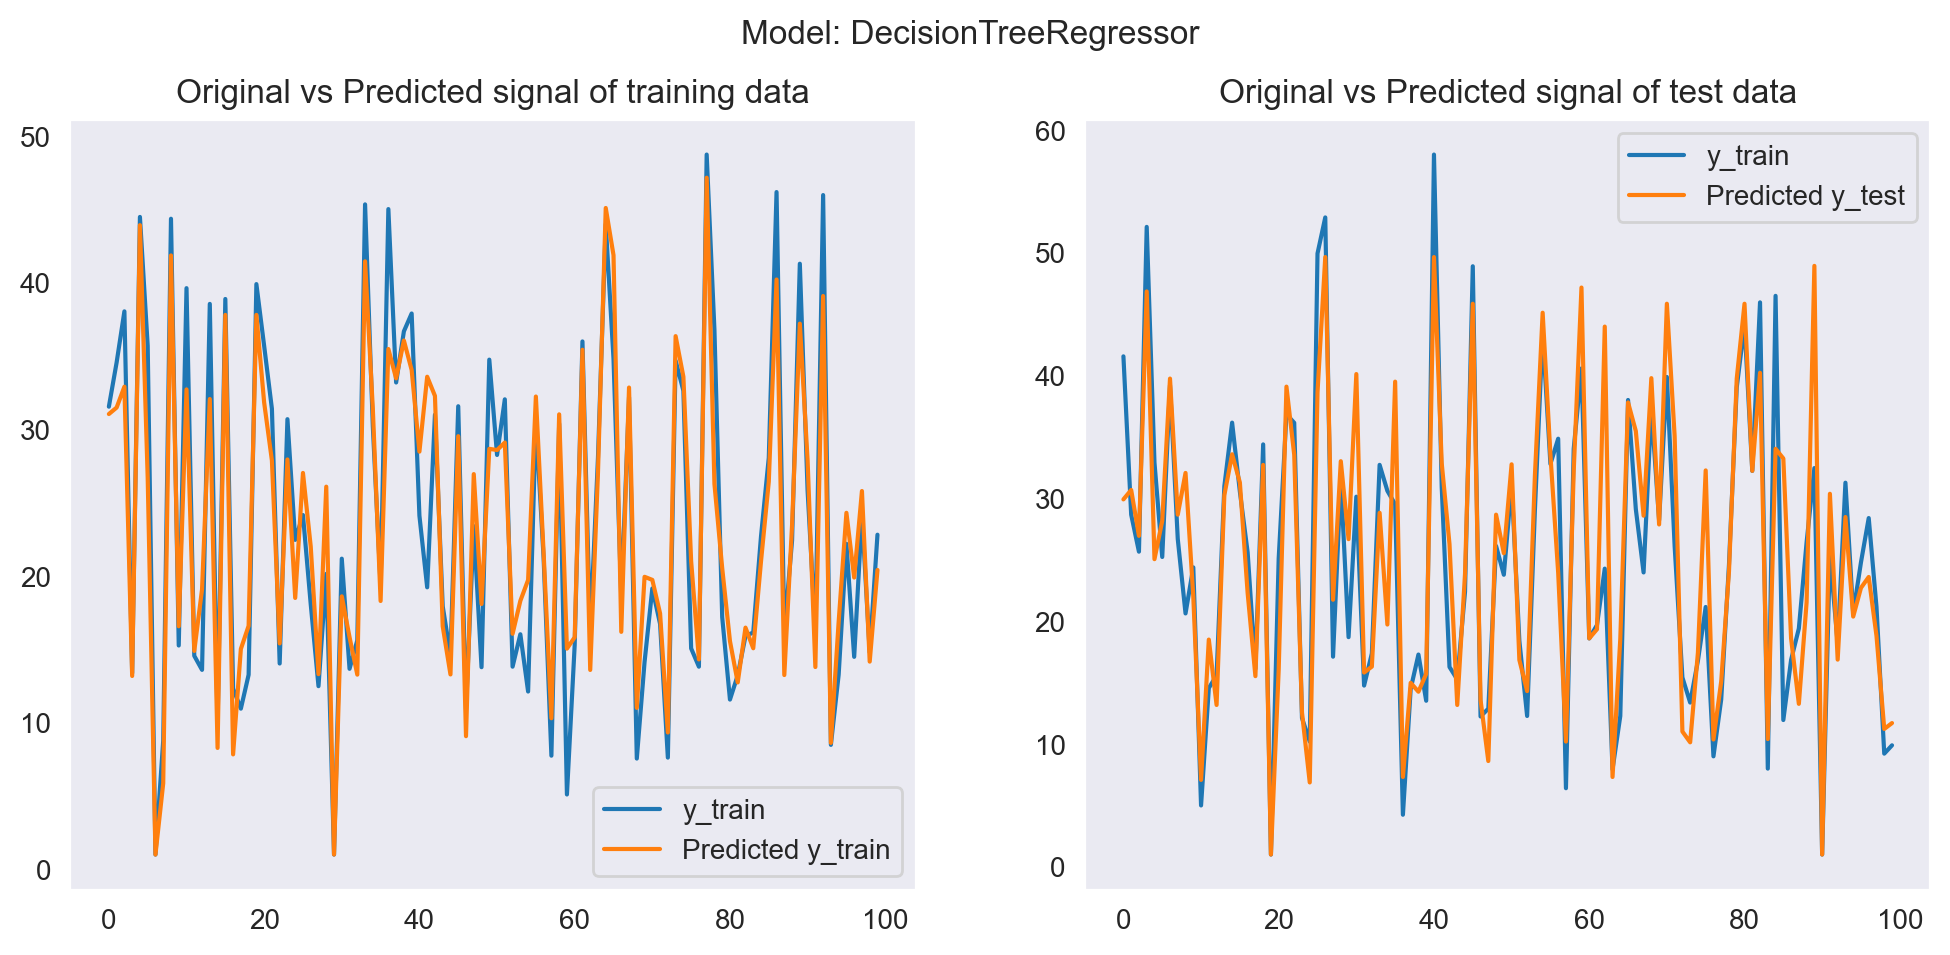

Train set evaluation results:
Mean squared error (MSE): 15.47
Root mean squared error (RMSE): 3.93
Mean absolute error (MAE): 2.68
R2 Square 0.9
Adjusted R2 sqaure 0.9


Test set evaluation results:
Mean squared error (MSE): 25.81
Root mean squared error (RMSE): 5.08
Mean absolute error (MAE): 3.39
R2 Square 0.83
Adjusted R2 sqaure 0.9


Mean of the residuals for DecisionTreeRegressor is: 0.2403065429772361


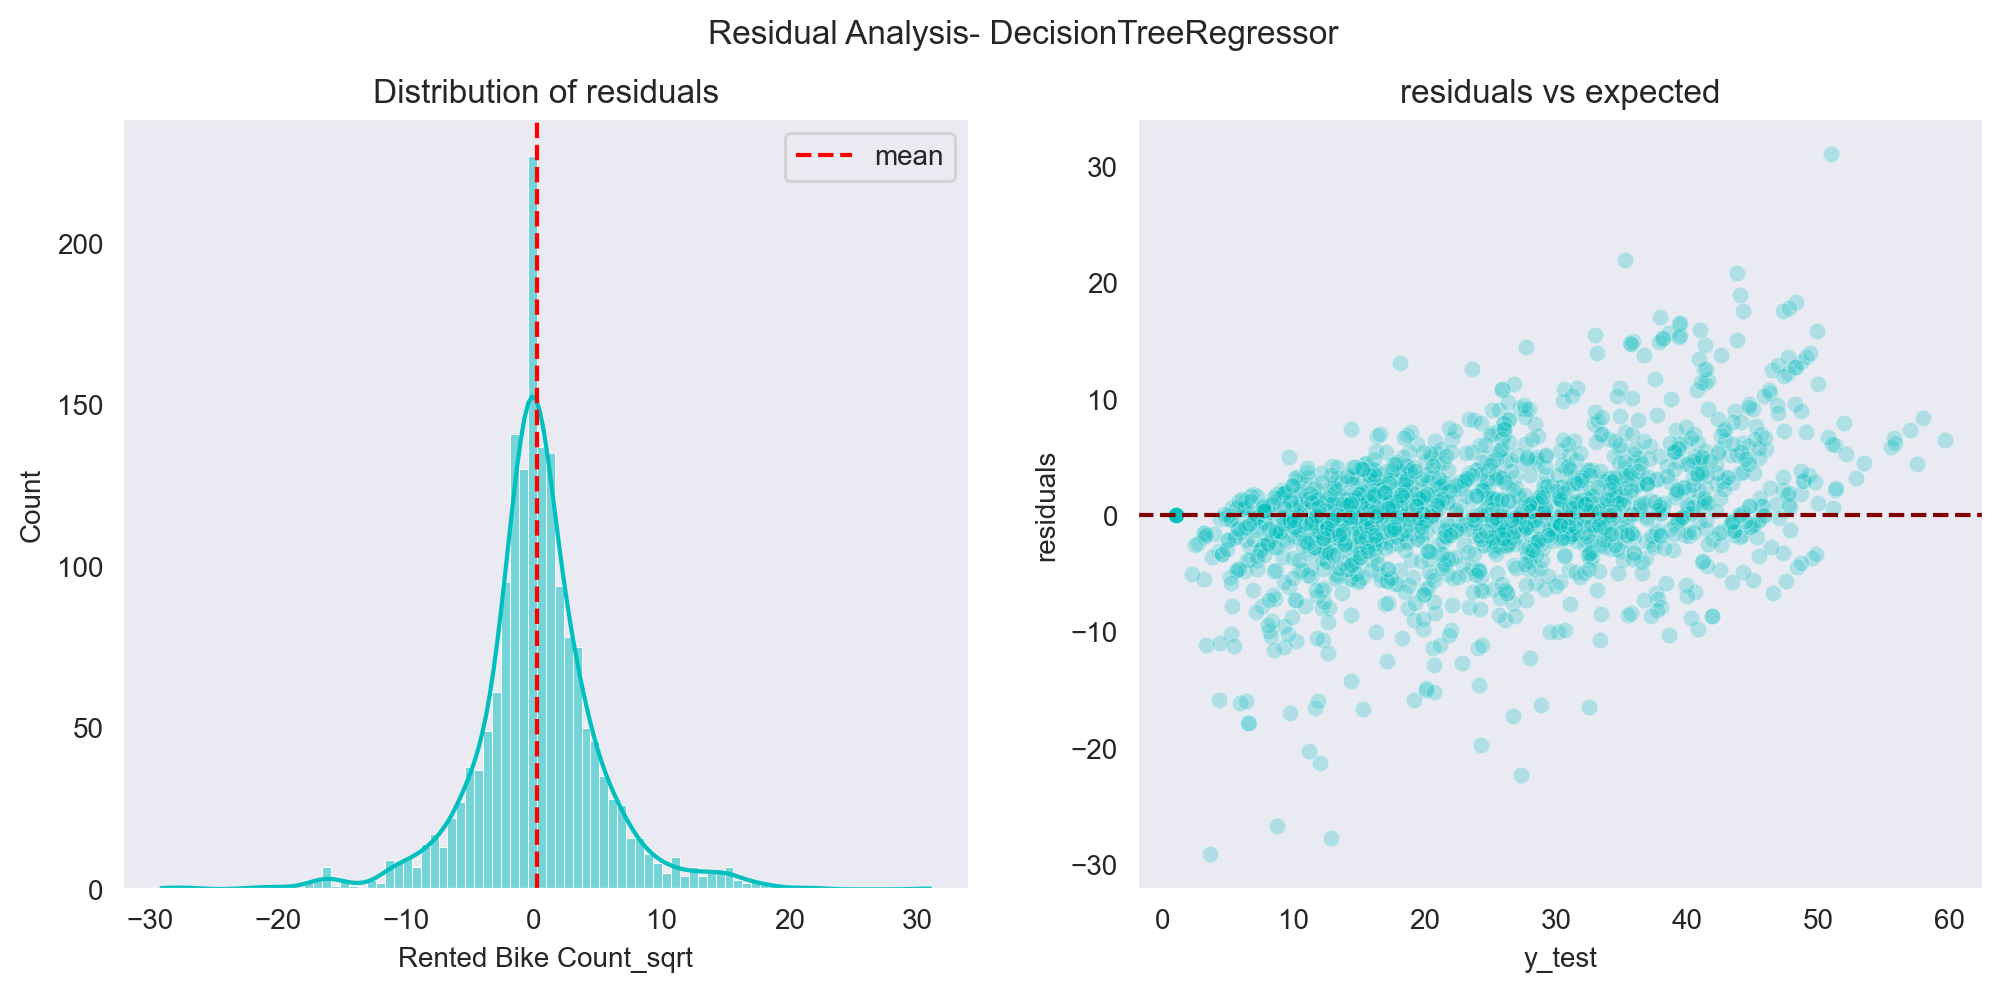

In [226]:
from sklearn.tree import DecisionTreeRegressor

dtree = DecisionTreeRegressor(max_leaf_nodes= 350, min_samples_leaf= 10, min_samples_split= 30, random_state=42)
preds, results = train_model(dtree, x_train, y_train, x_test, y_test)

- Decision tree regressor model substaintially improved model performance over linear model. However there are sign of overfitting as the performance of model on training data is better compared to test data.
- Residual plots also suggest imporvement in the goodness of fit of model. As the mean of residuals is approximately zero and residuals are normaly distributed also, the variance seems to be constant.

### 1.6 Random Forest Regressor

In [242]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(random_state=42)
param_dict = {'n_estimators':[100, 150, 200],
              'max_depth':[25, 30, 35],
              'min_samples_split':[10, 15, 20],
              'min_samples_leaf':[3, 4, 5]}
# rf_reg = GridSearchCV(rfr, param_dict, verbose=1, scoring='neg_mean_squared_error', cv=5)
# rf_reg.fit(x_train, y_train)
# print(rf_reg.best_params_)

In [244]:
from sklearn.model_selection import RandomizedSearchCV
rf_reg = RandomizedSearchCV(rfr, param_dict, verbose=1, scoring='neg_mean_squared_error', cv=5)
rf_reg.fit(x_train, y_train)
print(rf_reg.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_estimators': 80, 'min_samples_split': 15, 'min_samples_leaf': 3, 'max_depth': 30}


Score of the model : 0.94


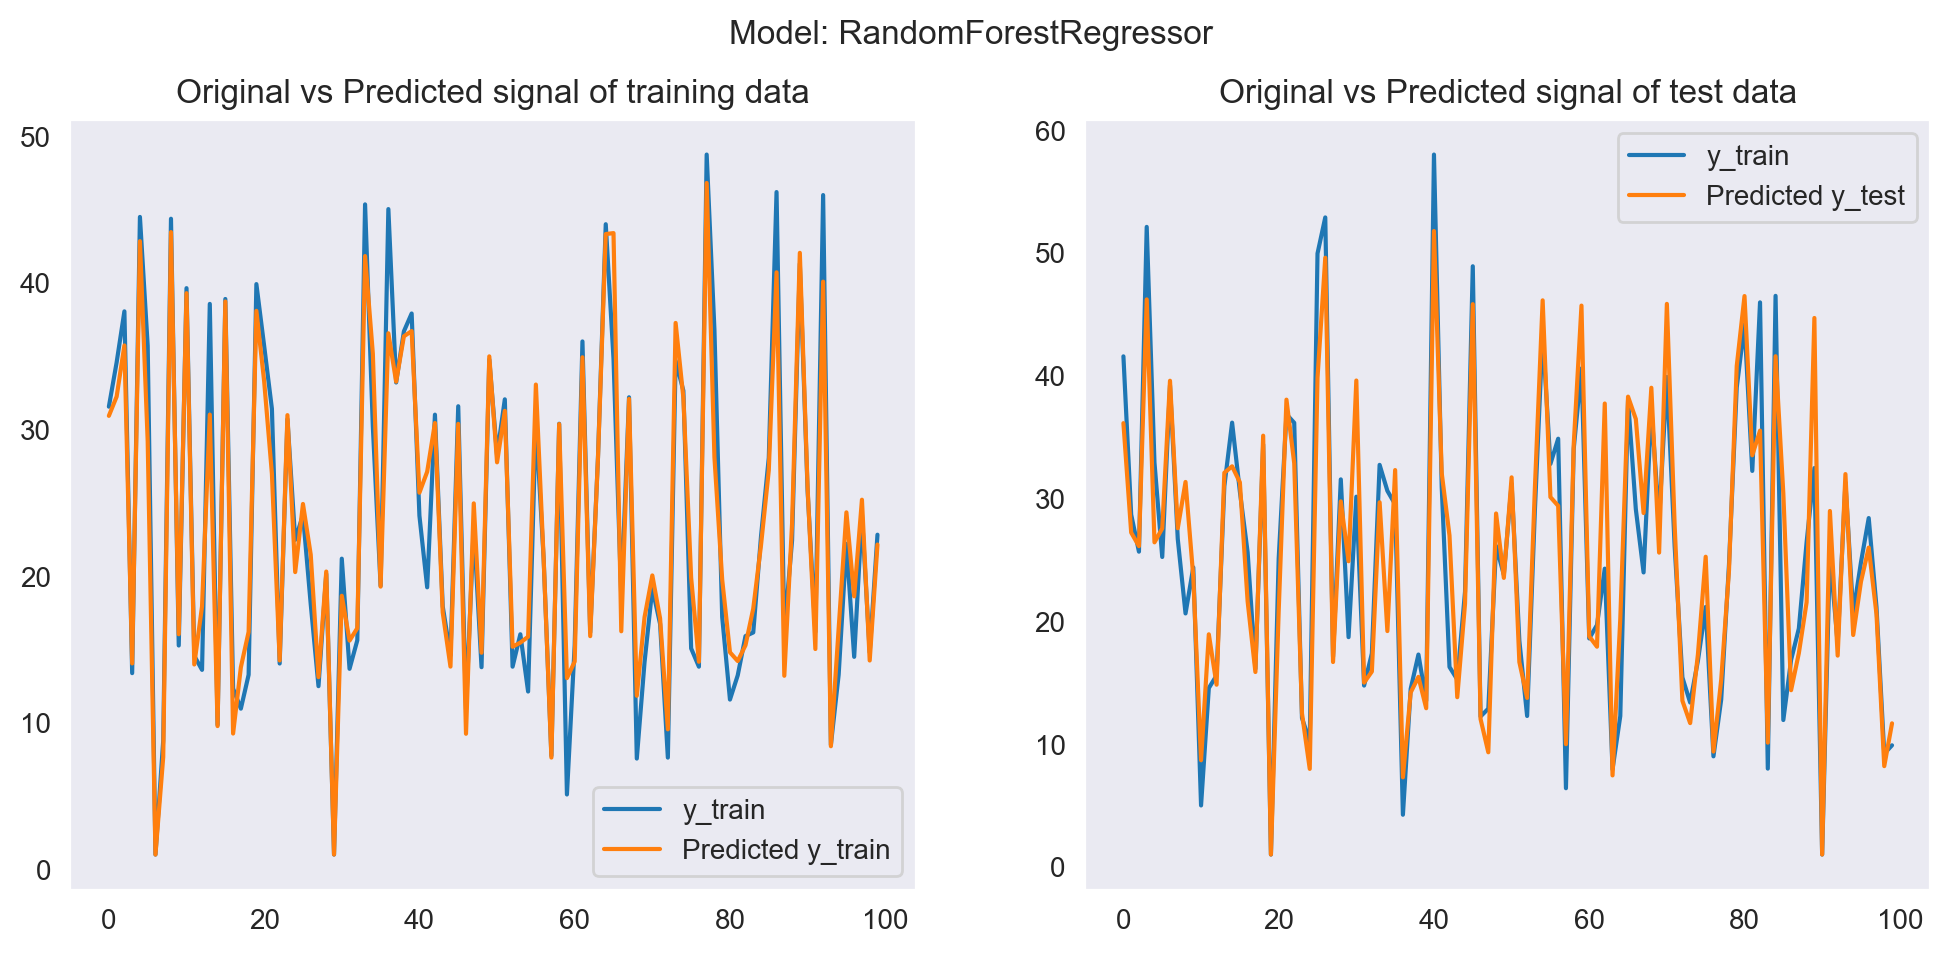

Train set evaluation results:
Mean squared error (MSE): 9.18
Root mean squared error (RMSE): 3.03
Mean absolute error (MAE): 2.03
R2 Square 0.94
Adjusted R2 sqaure 0.94


Test set evaluation results:
Mean squared error (MSE): 18.29
Root mean squared error (RMSE): 4.28
Mean absolute error (MAE): 2.81
R2 Square 0.88
Adjusted R2 sqaure 0.94


Mean of the residuals for RandomForestRegressor is: 0.1387271390417262


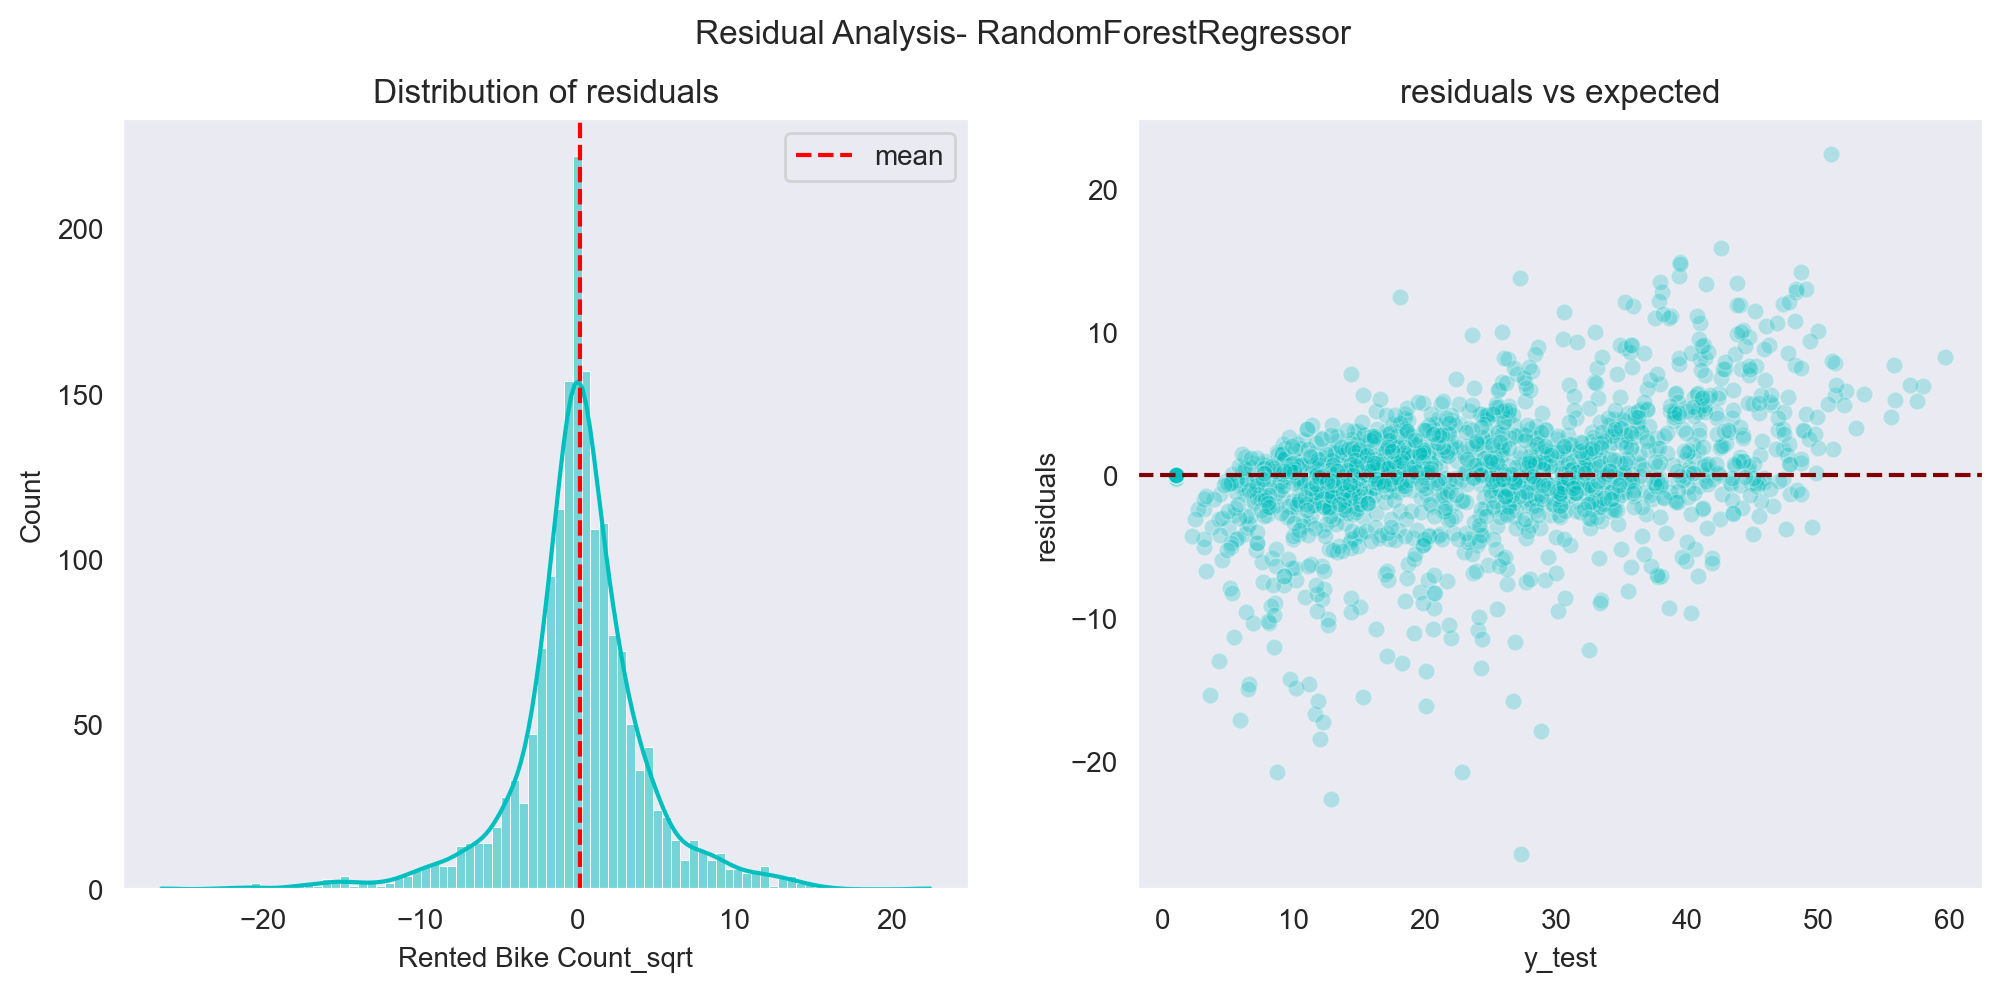

In [247]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=80,
                            min_samples_split=15,
                            min_samples_leaf=3,
                            max_depth=30,
                            random_state=42)

preds, results = train_model(rfr, x_train, y_train, x_test, y_test)

- The Random Forest regression model performs better than other Linear regression, Lasso, Ridge, ElasticNet, and Decision tree regression models.
- Cross validation and hyperparameter tuning improved the Random Forest regression model's performance.

### 1.7 Gradient Boosting Regressor

In [251]:
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import loguniform

gbr= GradientBoostingRegressor(random_state=42)

param_distributions = {
    'n_estimators': [150, 200],
    'max_depth':[20, 25, 30],
    'min_samples_split':[15, 20, 25],
    'min_samples_leaf':[4, 5, 6],
    "learning_rate": loguniform(0.01, 1),
}


gbr_reg = RandomizedSearchCV(
                                gbr,
                                param_distributions=param_distributions,
                                scoring="neg_mean_absolute_error",
                                n_iter=20,
                                random_state=42,
                            )

gbr_reg.fit(x_train, y_train)
print(gbr_reg.best_params_)

{'learning_rate': 0.05611516415334504, 'max_depth': 20, 'min_samples_leaf': 6, 'min_samples_split': 25, 'n_estimators': 200}


Score of the model : 1.0


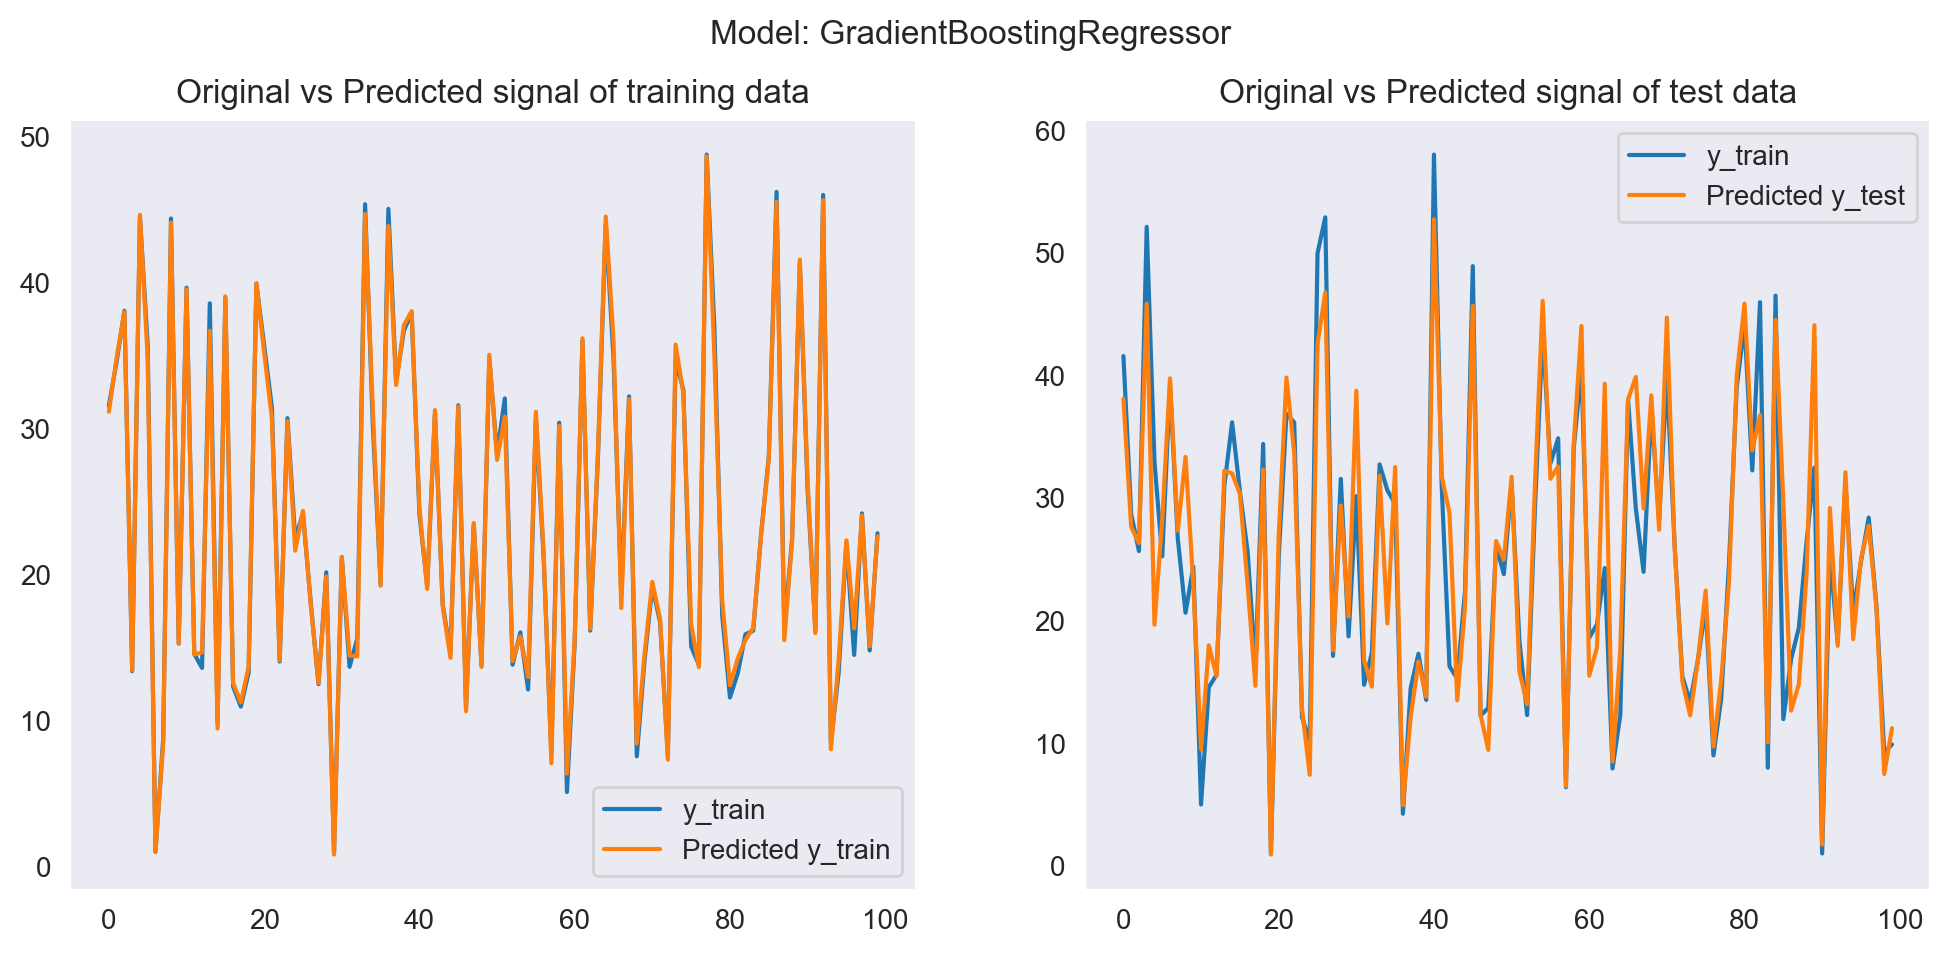

Train set evaluation results:
Mean squared error (MSE): 0.57
Root mean squared error (RMSE): 0.76
Mean absolute error (MAE): 0.49
R2 Square 1.0
Adjusted R2 sqaure 1.0


Test set evaluation results:
Mean squared error (MSE): 15.81
Root mean squared error (RMSE): 3.98
Mean absolute error (MAE): 2.48
R2 Square 0.9
Adjusted R2 sqaure 1.0


Mean of the residuals for GradientBoostingRegressor is: 0.1329923323918124


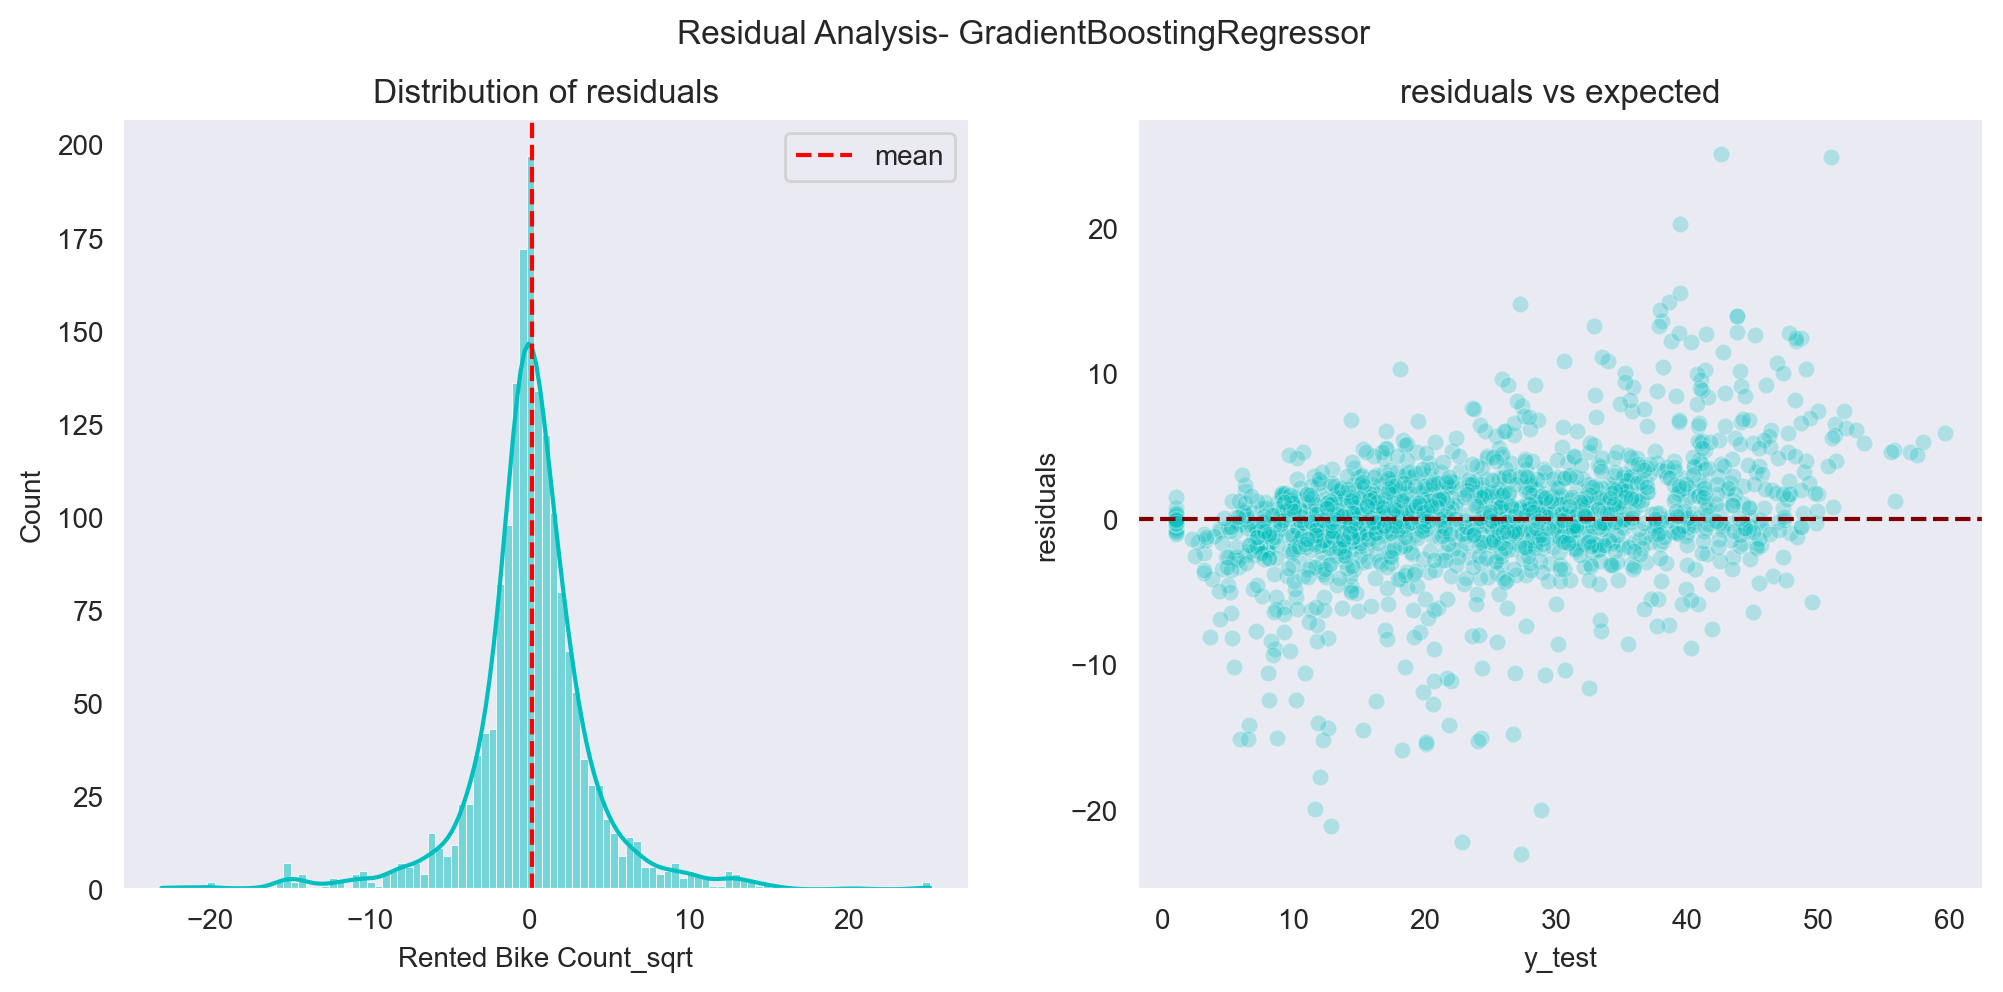

In [252]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(
                                    learning_rate=0.05611516415334504,
                                    n_estimators=200,
                                    min_samples_split=25,
                                    min_samples_leaf=6,
                                    max_depth=20,
                                    random_state=42
                                )

preds, results = train_model(gbr, x_train, y_train, x_test, y_test)

### 1.8 XGBoost

In [262]:
import xgboost as xgb
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import mean_squared_error

space={'n_estimators': hp.randint("n_estimators", 200),
        'max_depth': hp.randint("max_depth", 50),
        'min_samples_split' : hp.randint("min_samples_split", 200),
        'min_samples_leaf' : hp.randint("min_samples_leaf", 50),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        }

# Regression: 
def hyperparameter_tuning(space):
    model=xgb.XGBRegressor(
                           tree_method = 'approx',
                           n_estimators =space['n_estimators'], 
                           max_depth = int(space['max_depth']), 
                           gamma = space['gamma'],
                           reg_alpha = int(space['reg_alpha']),
                           min_child_weight=space['min_child_weight'],
                           colsample_bytree=space['colsample_bytree']
                          )
    
    evaluation = [( x_train, y_train), ( x_test, y_test)]
    
    model.fit(x_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

    pred = model.predict(x_test)
    mse= mean_squared_error(y_test, pred)
    
    return {'loss':mse, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print (best)

100%|██████████████████████████████████████████████| 100/100 [00:13<00:00,  7.46trial/s, best loss: 14.929809849596476]
{'colsample_bytree': 0.9713816883334179, 'gamma': 3.0305471964591906, 'max_depth': 43, 'min_child_weight': 6.0, 'min_samples_leaf': 6, 'min_samples_split': 100, 'n_estimators': 139, 'reg_alpha': 42.0}


In [266]:
hist_params = {'colsample_bytree': 0.943951973180915, 
               'gamma': 1.138995088602749, 
               'max_depth': 20, 
               'min_child_weight': 6.0, 
               'min_samples_leaf': 36, 
               'min_samples_split': 181, 
               'n_estimators': 57, 
               'reg_alpha': 40.0}

In [267]:
approx_params = {'colsample_bytree': 0.9713816883334179, 
                 'gamma': 3.0305471964591906, 
                 'max_depth': 43, 
                 'min_child_weight': 6.0, 
                 'min_samples_leaf': 6, 
                 'min_samples_split': 100, 
                 'n_estimators': 139, 
                 'reg_alpha': 42.0}

Score of the model : 0.96


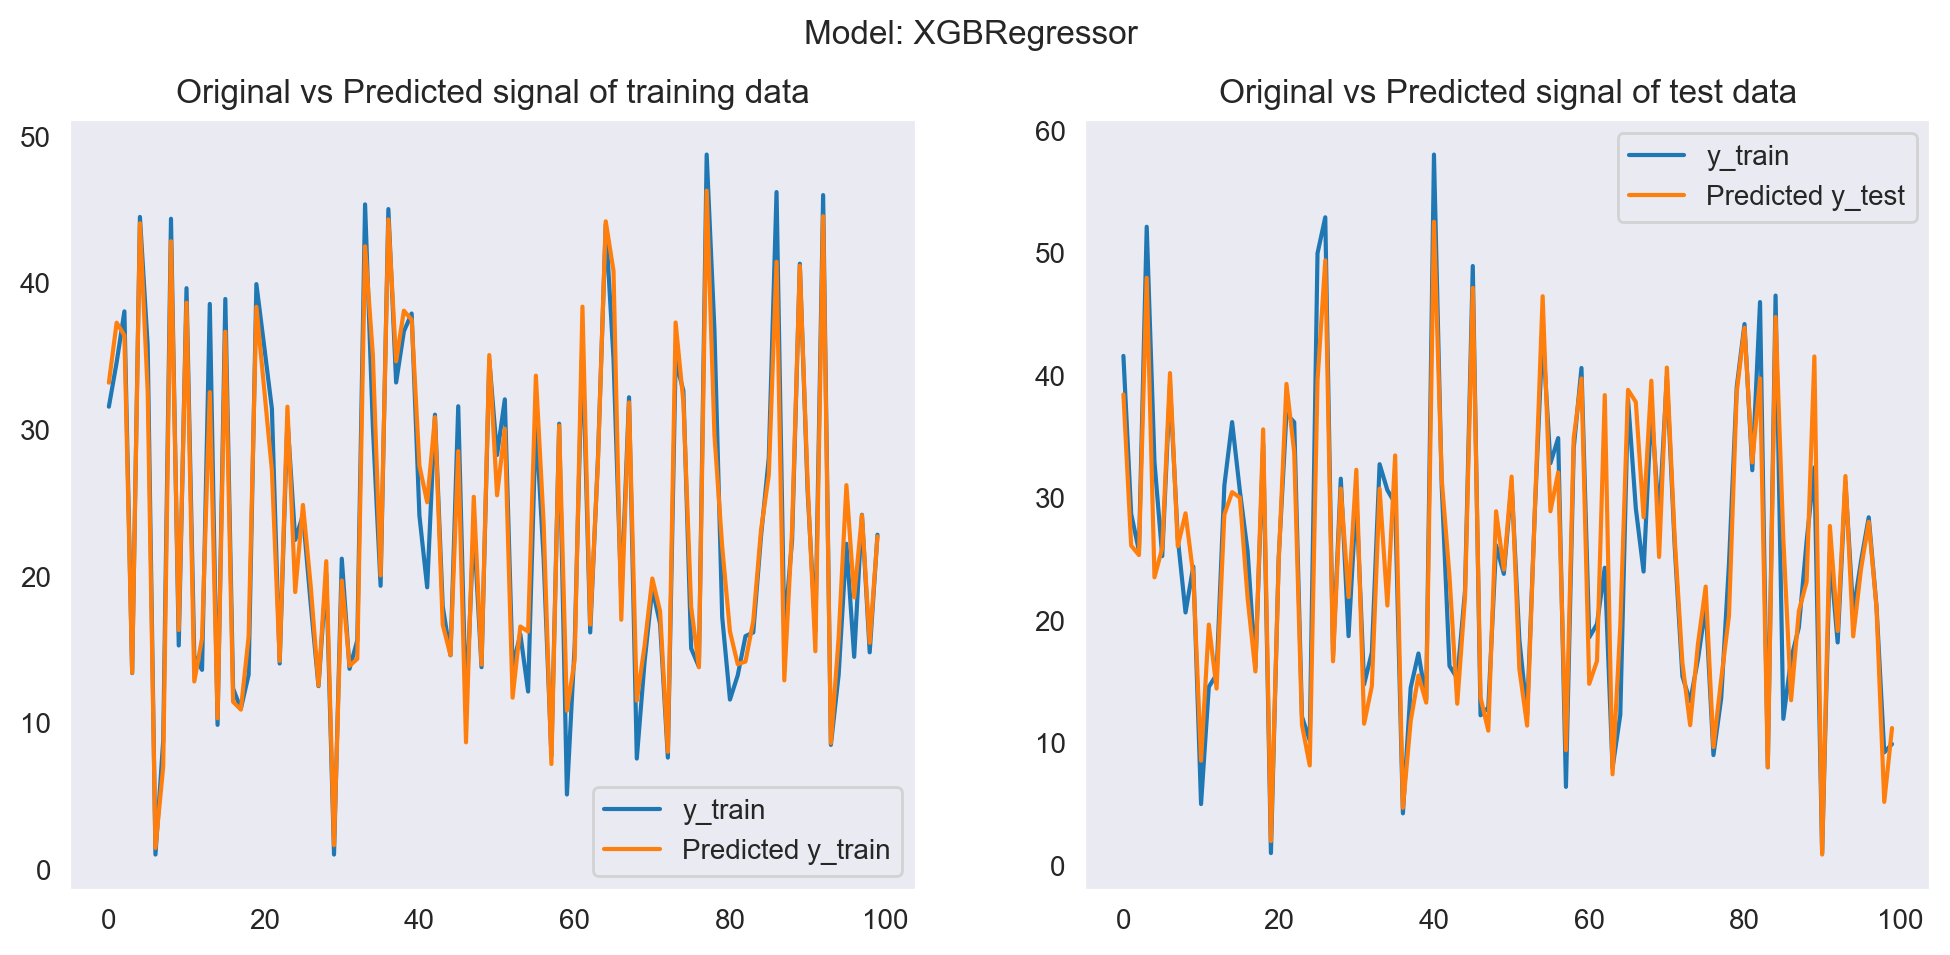

Train set evaluation results:
Mean squared error (MSE): 6.49
Root mean squared error (RMSE): 2.55
Mean absolute error (MAE): 1.81
R2 Square 0.96
Adjusted R2 sqaure 0.96


Test set evaluation results:
Mean squared error (MSE): 14.93
Root mean squared error (RMSE): 3.86
Mean absolute error (MAE): 2.56
R2 Square 0.9
Adjusted R2 sqaure 0.96


Mean of the residuals for XGBRegressor is: 0.0795206622793411


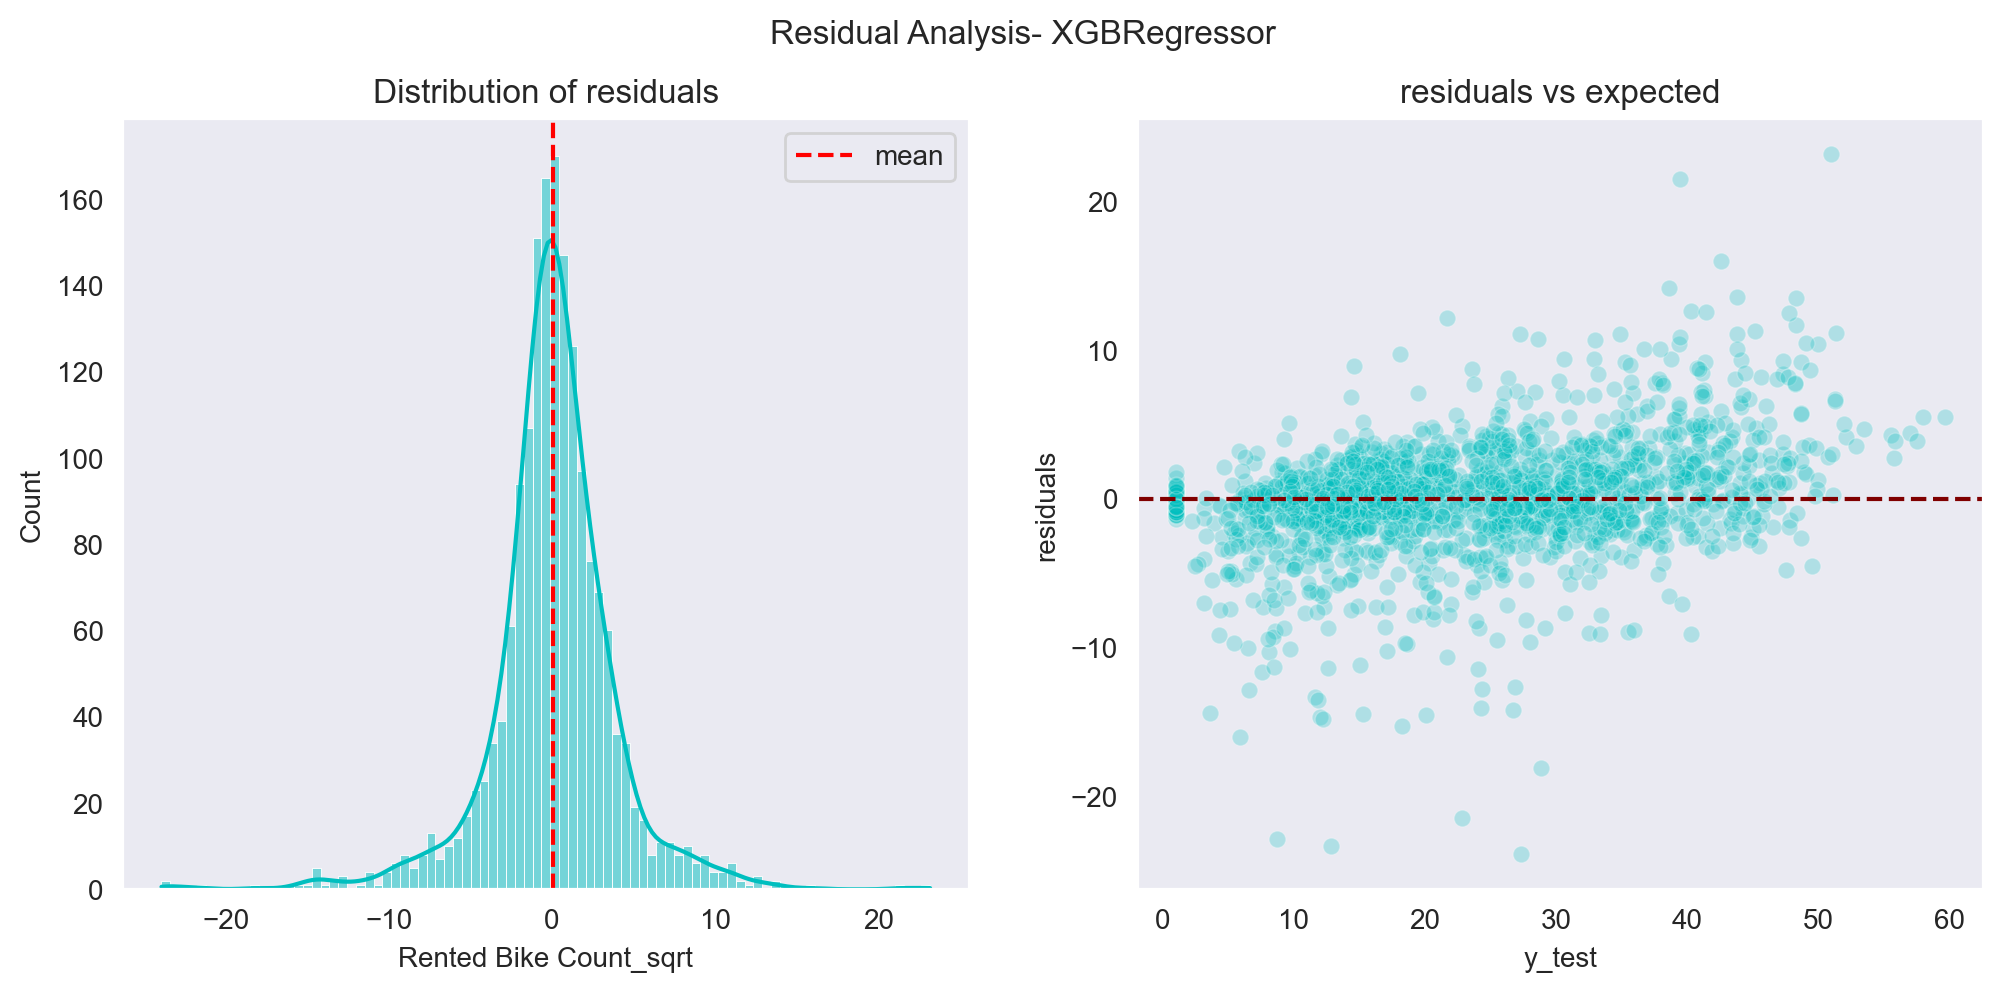

In [269]:
import xgboost as xgb

xgbr = xgb.XGBRegressor(
                           tree_method = 'approx',
                           n_estimators =     approx_params['n_estimators'], 
                           max_depth =        approx_params['max_depth'], 
                           gamma =            approx_params['gamma'],
                           reg_alpha =        approx_params['reg_alpha'],
                           min_child_weight=  approx_params['min_child_weight'],
                           colsample_bytree=  approx_params['colsample_bytree']
                          )

preds, results = train_model(xgbr, x_train, y_train, x_test, y_test)

## Model Selection

In [309]:
measures['LinearRegression']['train_set_results']


{'mse': 64.65964938168044,
 'rmse': 8.041122395641073,
 'mae': 6.2195585844276104,
 'r2': 0.5784293723452782,
 'adjusted_r2': 0.5777061632628113}

In [308]:
pd.DataFrame(index= (pd.Series(measures['LinearRegression']['train_set_results'])).index)

Empty DataFrame
Columns: []
Index: [mse, rmse, mae, r2, adjusted_r2]

In [310]:
def get_metrics_df(measures):
    
    """
    takes a nested dictionary dictionary and returns seperate dataframes
    
    """
    
    idx = (pd.Series(measures['LinearRegression']['train_set_results'])).index

    train_metrics_df = pd.DataFrame(index=idx)
    test_metrics_df = pd.DataFrame(index=idx)

    for key in measures.keys():

        train_metrics = measures[key]['train_set_results']
        train_series = pd.Series(train_metrics)
        train_metrics_df[key] = train_series.values

        test_metrics = measures[key]['test_set_results']
        test_series = pd.Series(test_metrics)
        test_metrics_df[key] = test_series.values

    return train_metrics_df, test_metrics_df
    

In [295]:
def compare_metrics(measures):
    
    df = pd.DataFrame(measures)
    
    colors = ['#FF0000', '#00FF00', '#0000FF', '#00FFFF', '#FF00FF', '#FFFF00', '#FFA500', '#800080', '#008080', '#FF1493']
    
    plt.subplots(2, 1, figsize=(13, 23))
    
    for i, col in enumerate(df.columns):
        
        train_set_results = pd.Series(measure_df.loc['train_set_results',col])
        test_set_results = pd.Series(measure_df.loc['test_set_results',col])
                    
        plt.subplot(211)
        plt.plot(train_set_results.index, train_set_results.values, marker = 'D', color=colors[i], label=col)
        plt.legend()
        plt.title("Performance of Models on Training Set")
        
        plt.subplot(212)
        plt.plot(test_set_results.index, test_set_results.values, marker = 's', color=colors[i], label=col)
        plt.legend()
        plt.title("Performance of Models in Test Set")
        
        
    plt.savefig(os.path.join('../graphs', 'model_performance_comparison'))
    plt.show()
    

In [313]:
train_metrics_df, test_metrics_df = get_metrics_df(measures)

print('=='*40)
print('Model Performance on Trainig Set:')
print('=='*40)
display(train_metrics_df)

print('=='*40)
print('Model Performance on test Set:')
print('=='*40)
display(test_metrics_df)

Model Performance on Trainig Set:


LinearRegression      Lasso      Ridge  ElasticNet  \
mse                 64.659649  64.659763  64.659654   64.659707   
rmse                 8.041122   8.041129   8.041123    8.041126   
mae                  6.219559   6.219768   6.219573    6.219621   
r2                   0.578429   0.578429   0.578429    0.578429   
adjusted_r2          0.577706   0.577705   0.577706    0.577706   

             DecisionTreeRegressor  RandomForestRegressor  \
mse                      15.472123               9.184629   
rmse                      3.933462               3.030615   
mae                       2.676446               2.027254   
r2                        0.899124               0.940118   
adjusted_r2               0.898951               0.940015   

             GradientBoostingRegressor  XGBRegressor  
mse                           0.571324      6.491443  
rmse                          0.755860      2.547831  
mae                           0.491633      1.805418  
r2                            0.996275      0.957677  
adjusted_r2                   0.996269      0.957604

Model Performance on test Set:


LinearRegression      Lasso      Ridge  ElasticNet  \
mse                 67.709184  67.699785  67.708104   67.705109   
rmse                 8.228559   8.227988   8.228493    8.228311   
mae                  6.271098   6.271013   6.271096    6.271090   
r2                   0.554750   0.554812   0.554757    0.554777   
adjusted_r2          0.577706   0.577705   0.577706    0.577706   

             DecisionTreeRegressor  RandomForestRegressor  \
mse                      25.813885              18.293393   
rmse                      5.080737               4.277078   
mae                       3.385134               2.811702   
r2                        0.830250               0.879704   
adjusted_r2               0.898951               0.940015   

             GradientBoostingRegressor  XGBRegressor  
mse                          15.806533     14.929810  
rmse                          3.975743      3.863911  
mae                           2.480842      2.557693  
r2                            0.896058      0.901823  
adjusted_r2                   0.996269      0.957604

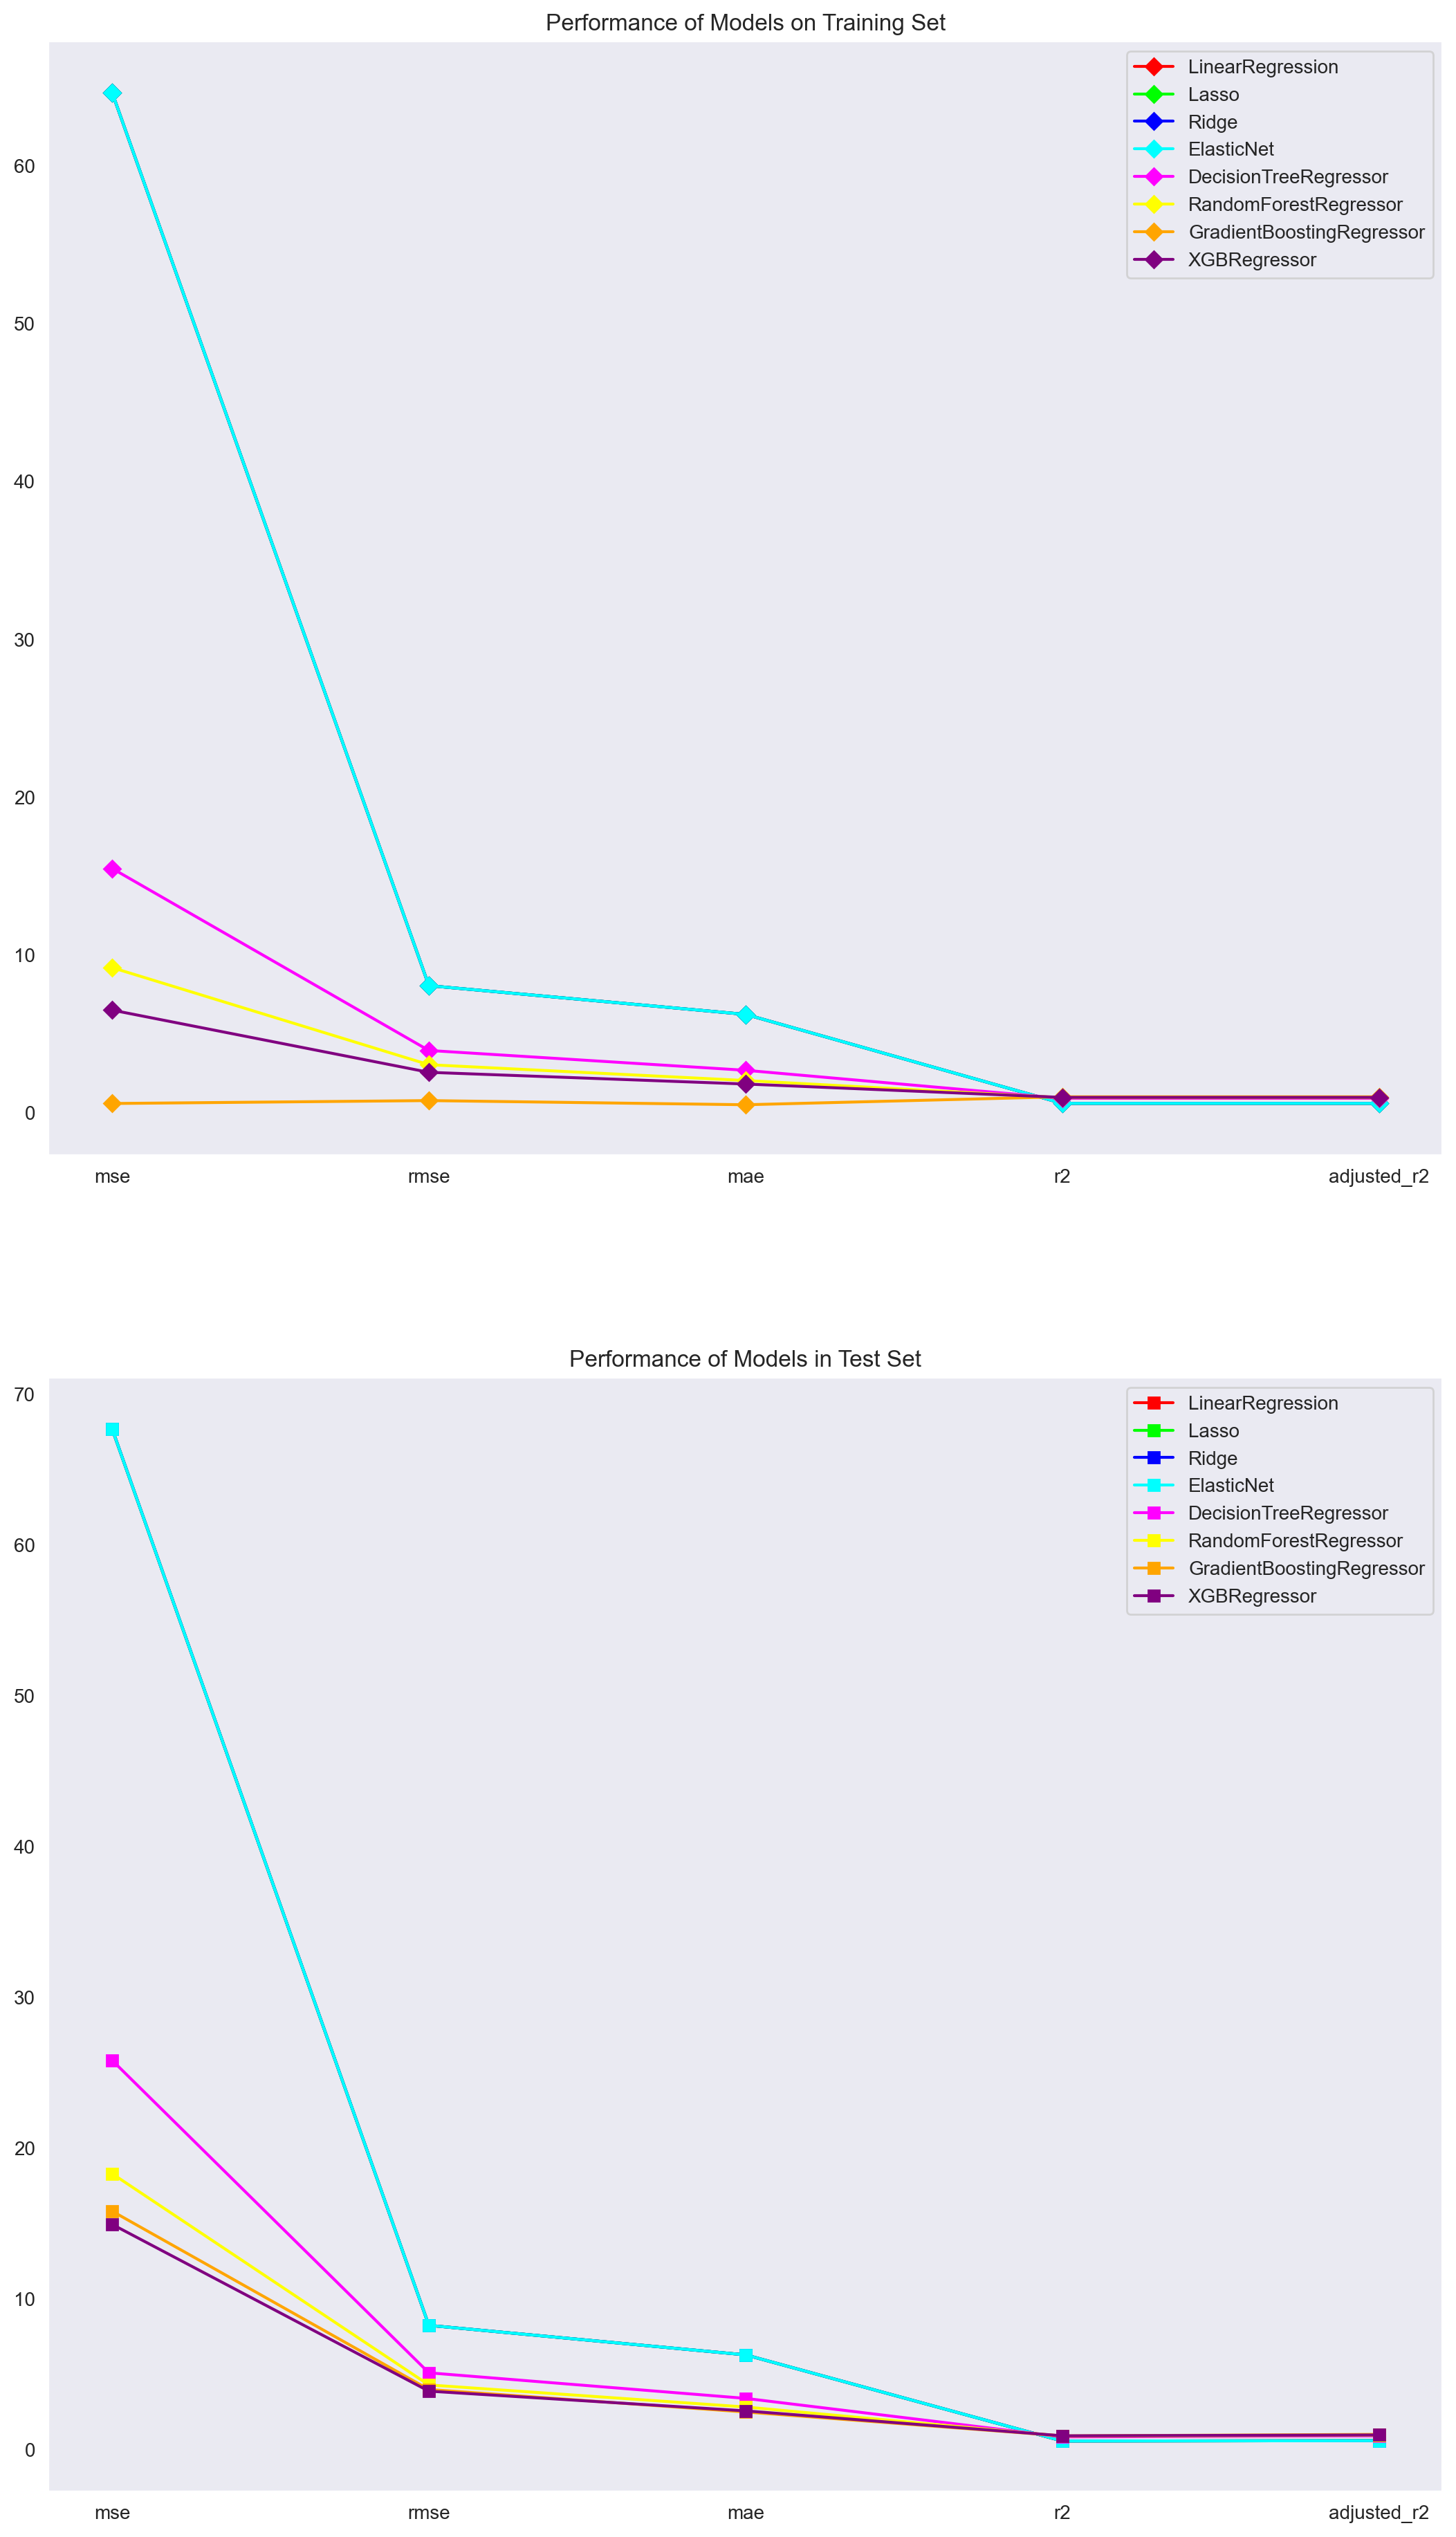

In [296]:
compare_metrics(measures)

In [314]:
train_metrics_df.to_csv('../metrics/train-set-performance-original-data.csv', header=True, index=False)
test_metrics_df.to_csv('../metrics/test-set-performance-original-data.csv', header=True, index=False)

## Conclusion
- **The XGBoost regression model has the highest R-squared score, the lowest Root Mean Squared Error (RMSE), and has very close to having zero mean of residuals.**
- **Therefore, the XGBoost regression model is the ideal model and well-trained for forecasting the number of rented bikes required per hour based on the model's high accuracy, low error, and zero mean of residuals.**